# HMM Training Tutorial

Welcome to the training tutorial! Since Homomorph doesn't have built-in methods for fitting HMMs to data, in this tutorial we'll cover examples of training HMMs where the hidden states are both known and unknown using maximum likelihood estimation and the estimation-maximization algorithm, respectively. We'll then discuss an advanced approach called discriminative training. Each one of these scenarios is broken into a different section or subsection, so I've included a table of of contents that will allow you to navigate directly to each.

- [1 What is training?](#1-What-is-training?)
  - [1.1 Training, informally](#1.1-Training,-informally)
  - [1.2 Training, formally](#1.2-Training,-formally)
- [2 Training with known states](#2-Training-with-known-states)
  - [2.1 Maximum likelihood estimation](#2.1-Maximum-likelihood-estimation)
  - [2.2 Maximum likelihood estimates for HMMs](#2.2-Maximum-likelihood-estimates-for-HMMs)
  - [2.3 Examples](#2.3-Examples)
    - [2.3.1 Categorical emission distribution](#2.3.1-Categorical-emission-distribution)
    - [2.3.2 Discrete emission distribution](#2.3.2-Discrete-emission-distribution)
    - [2.3.3 Continuous emission distribution](#2.3.3-Continuous-emission-distribution)
- [3 Training with unknown states](#3-Training-with-unknown-states)
  - [3.1 Estimation-maximization, informally](#3.1-Estimation-maximization,-informally)
  - [3.2 Implementing Baum-Welch for categorical distributions](#3.2-Implementing-Baum-Welch-for-categorical-distributions)
  - [3.3 Estimation-maximization, formally](#3.3-Estimation-maximization,-formally)
  - [3.4 Deriving the update equations for a normal distribution](#3.4-Deriving-the-update-equations-for-a-normal-distribution)
- [4 Discriminative training](#4-Discriminative-training)
  - [4.1 Discriminative training theory](#4.1-Discriminative-training-theory)
  - [4.2 Deriving the update equations for normal distributions](#4.3-Deriving-the-update-equations-for-normal-distributions)
  - [4.3 Labeling data with a misspecified model](#4.3-Labeling-data-with-a-misspecified-model)
- [5 Conclusion](#5-Conclusion)

The material in sections two and three owes a heavy debt to two sources, respectively. The first is the book *[Biological Sequence Analysis](https://doi.org/10.1017/CBO9780511790492)*, which is an excellent resource on HMMs and other probabilistic models and their applications to biological sequence data. The second is the paper [Hidden Neural Networks](https://doi.org/10.1162/089976699300016764) by Anders Krogh and Søren Riism. Many of the theoretical results for HMMs shown here are adapted or expanded from the derivations outlined in those references, so this tutorial wouldn't have been possible without them.

Anyway, we have a lot of ground to cover, so let's get started!

## 1 What is training?

### 1.1 Training, informally

Training and learning are jargon commonly used in machine learning. While convenient as shorthand, I feel they're over-used since they obscure what's actually happening: parameter estimation or, more generally, optimization. Statistical models are specified by some number of parameters, so the name of the game is choosing parameters that fit the data the best. Depending on the model, this can be as simple as taking an average or as complex as needing specialized algorithms and thousands of computing hours. Note that the notion of a "best" fit to the data isn't always immediately obvious, and some applications will define it differently. (We'll see at least two distinct definitions in the following sections.) In every case, however, some quantity of interest is defined that is hopefully correlated with the ability to predict real-world outcomes, and then some computational method is used to find parameters that maximize or minimize that quantity.

### 1.2 Training, formally

Now that we understand what training is intuitively, let's briefly talk about how it's defined mathematically. This section will mainly serve to introduce some terminology that we'll use throughout this tutorial, but it will also highlight the features that are common to all optimization problems regardless of application or mathematical form.

At the core of every optimization problem is a function whose output is optimized with respect to one or more inputs. This is called the *objective function* or simply the *objective*. This terminology is common when discussing optimization generically, and the kind of extremum (minimum or maximum) is unstated. In machine learning and statistics, however, the objective is often framed as a kind of distance between the model's output and the actual data. Distance has a very specific meaning in mathematics, so we instead call this quantity *loss*. Naturally, then, the goal is to minimize loss. Unlike in many optimization problems where the optimal value of the objective is as important as the inputs that achieve that optimum, when fitting models the loss is often only a means to an end. Though the loss has applications when comparing the fits of different models, the optimized parameters are typically the ultimate goal.

The form of the loss function depends on the exact nature of the problem, so it's difficult to go any further without speaking in overly general terms. Thus, to illustrate these concepts mathematically, we'll use an extremely common loss function, the mean squared error. Let's now define the data, model, and loss precisely. The data, $D$, are composed of $N$ examples which are the indexed ordered pairs $\{(x_i, y_i):1 \le i \le N\}$. Each $x_i$ and $y_i$ is an input and output, respectively. Though these quantities can be vector-valued, we'll keep our discussion general enough to not have to worry about these details. The model is a function, $f$, which accepts an input, $x$, and returns an output, $\hat{y}$. The output is designated with a hat to indicate it was calculated from the model rather than observed. This function also accepts a set of parameters, $\Theta$, which we can tune to better fit the data. Thus, we write $\hat{y} = f(x, \Theta)$. Finally the loss function, $L$, accepts the data, model, and parameters and returns a measure of the deviation from the data, $L(D, f, \Theta)$. For the mean squared error, we can write this as

$$
\begin{aligned}
L(D, f, \Theta)
&= \frac{1}{N} \sum_{i=1}^N \left( \hat{y}_i - y_i \right)^2 \\
&= \frac{1}{N} \sum_{i=1}^N \left( f(x_i, \Theta) - y_i \right)^2. \\
\end{aligned}
$$

In this case, the loss is expressed as a sum over individual examples. This is extremely common, so losses are frequently written in terms of an individual input and output pair rather than the data as a whole. Furthermore, since the data and model are usually fixed, they are often dropped as arguments, making the loss a function of the parameters alone:

$$
L(D, f, \Theta) = L(\Theta).
$$

Now we can write our optimized parameters as

$$
\DeclareMathOperator*{\argmax}{arg\!\max}
\DeclareMathOperator*{\argmin}{arg\!\min}
\hat{\Theta} = \argmin_\Theta L(\Theta).
$$


Finding these minimum parameters is not always straightforward. For simple models, such as one-dimensional linear regression where $f(x, \Theta) = \theta_1 x + \theta_0$, there are closed-form solutions. However, many modern machine learning models offer no such luxury, so other approaches are needed. There are various techniques for such cases depending on the structure of the model. However, they are all usually iterative in nature, meaning they gradually decrease the loss in a series of steps. For complex models and large data sets, each of these steps can involve significant computation, which is why these models are often trained on computational clusters with specialized hardware.

## 2 Training with known states

Sometimes the universe is kind and gives us data where the underlying states are known. This is by far the easiest case since all the information is available to us, and as HMMs are probabilistic models, we can rely on the rich theory of mathematical statistics to define optimality and identify the corresponding parameters. Depending on the emission distributions, there are even closed-form solutions for these optimal parameters!

### 2.1 Maximum likelihood estimation

The strength of probabilistic models is that for a given set of parameters, every possible input is associated with a probability or probability density, so objective functions are naturally defined in terms of these quantities. This doesn't answer question of what probability we should try to optimize, however. There are several common approaches, but one of the most natural is to maximize the probability of the data with respect to the parameters. Let's clarify what this means by writing it mathematically. We'll call our data, which is a set of indexed observations $\{x_i:1 \le i \le N\}$, $D$ and the probability mass function $f(x, \Theta) = P(X = x | \Theta)$. (The right-hand side translates to "the probability that the random variable called $X$ assumes the value $x$ given the set of parameters $\Theta$. In probability, the random processes that generate observations are distinguished from the observations themselves.) The probability of the data is then written as

$$
\begin{aligned}
P(D|\Theta)
&= \prod_{i=1}^N P(X=x_i | \Theta) \\
&= \prod_{i=1}^N f(x_i, \Theta) \\
\end{aligned}
$$ 

since each observation is independent and identically distributed. Sums are easier to work with, so it's common to take the logarithm of both sides and call the result

$$
L(\Theta) = \log P(D|\Theta) = \sum_{i=1}^N \log f(x_i, \Theta)
$$

the *log-likelihood function*. The original product then is the *likelihood function*; however, the logarithm doesn't change the position of the extrema, so this distinction is not very important for our purposes.

Before moving forward, I want to make a few comments about the likelihood function. First, even though we defined it in terms of observations that assume discrete values (notice that $f$ is probability rather than a probability **density**), the definition is the same for continuous observations. The only difference is we can no longer consider the likelihood as a probability since it is technically a probability density. However, this not a common interpretation anyway since even for discrete data the probability of any sequence of observations approaches zero as the number of observations increases. It's instead more useful to compare ratios of likelihoods under different models. That, however, is a topic for another time. Another subtle point is the likelihood function is **not** the probability that the parameters are correct. We instead view a particular choice of parameters as certain and then calculate the probability of the data given that choice. Finally, as with the mean squared loss we defined earlier, though the likelihood is technically a function of both the parameters and the data, the data are often dropped as an argument to emphasize that they are typically fixed.

For probabilistic models, the log-likelihood function is a natural, though not the only, choice for the objective. Unlike for a loss function, we want to maximize the log-likelihood since this maximizes the probability of the data under the model. This defines the following set of parameters

$$
\hat{\Theta} = \argmax_\Theta L(\Theta)
$$

which are known as *maximum likelihood estimates* (MLEs). Though this objective isn't quite a loss in the sense of a distance from some desired outputs, it's actually very close. Since the model should assign common events high probabilities (and accordingly rare events low probabilities since the total probability is constrained to sum to one), the log-likelihood in effect penalizes deviations from the empirical distribution. In fact, simply negating the log-likelihood function converts the maximization into a minimization, making it a kind of loss. Furthermore, for some models further manipulations can reveal an algebraic expression which is more readily interpreted as a distance.

Calculus tells us that for differentiable functions local extrema are necessarily where the derivative relative to the parameter is zero. If $\Theta$ is actually a set of $N$ parameters, this condition must occur simultaneously for the derivative relative to each. In other words,

$$
\frac{\partial L}{\partial \Theta_1} = 0, \quad \ldots, \quad \frac{\partial L}{\partial \Theta_N} = 0.
$$

In some cases these equations can be solved explicitly, but often numerical techniques are needed. We'll see two examples of such approaches in later sections.

### 2.2 Maximum likelihood estimates for HMMs

#### 2.2.1 Decomposition into independent products

Now let's turn to HMMs and derive the MLEs for labeled data. Here the data, $D$, are again composed of $N$ examples of ordered pairs $\{(x_i, y_i)|1 \le i \le N\}$ where $x_i$ is a sequence of states and $y_i$ is a sequence of emissions, each with length $T_i$. The probability of the data given the parameters is then

$$
\begin{aligned}
P(D|\Theta)
&= P(X_1=x_1, Y_1=y_1, \ldots, X_N=x_N, Y_N=y_N|\Theta) \\
&= \prod_{i=1}^N P(X_i=x_i, Y_i=y_i|\Theta). \\
\end{aligned}
$$

The joint probability expands into a product of the probabilities of individual examples since each is independent and identically distributed. Let's now focus on one pair of state and emission sequences denoted $x$ and $y$, each with length $T$. Using the Markov property of HMMs, we can derive an expression for their joint probability:

$$
\begin{aligned}
P(D|\Theta)
&= P(X=x, Y=y|\Theta) \\
&= P(Y_1=y_1|X_1=x_1,\Theta) P(X_1=x_1|\Theta)
   \prod_{t=1}^{T-1} P(Y_{t+1}=y_{t+1}|X_{t+1}=x_{t+1},\Theta) P(X_{t+1}=x_{t+1}|X_t=x_t,\Theta). \\
\end{aligned}
$$

(Note that here when we use subscripts, we're referring to the index **within** a sequence rather than the index of the example.)

All these capital letters are making this expression a little busy, so let's make a few common substitutions to simplify it. First, we'll assume there are $S$ states numbered from $1$ to $S$ and write the transition and start probabilities as $P(X_{t+1}=j|X_t=i, \Theta) = a_{ij}$ and $P(X_1=i|\Theta) = a_{0i}$, respectively. Finally, we'll define $e_i(y_t) = P(Y_t=y_t|X_t=i, \Theta)$. We can think of each $e_i$ as a function that accepts an emission $y_t$ and outputs a probability or probability density. Putting all this together, we have

$$
P(X=x, Y=y|\Theta) = e_{x_1}(y_1)a_{0x_1} \prod_{t=1}^{T-1} e_{x_{t+1}}(y_{t+1}) a_{x_t x_{t+1}}.
$$

Since we generally work with log-likelihoods, let's take the logarithm of both sides and write the product as a sum of log terms:

$$
\begin{aligned}
\log P(X=x, Y=y|\Theta)
&= \log \left( e_{x_1}(y_1)a_{0x_1} \prod_{t=1}^{T-1} e_{x_{t+1}}(y_{t+1}) a_{x_t x_{t+1}} \right) \\
&= \log a_{0x_1} + \sum_{t=1}^{T-1} \log a_{x_t x_{t+1}} + \sum_{t=1}^T \log e_{x_t}(y_t). \\
\end{aligned}
$$

This is now a fairly clean expression since at each step we "pick" the right transition probability and emission distribution using the state sequence. However, it will be useful both theoretically and computationally to write this expression in terms of the number of times each transition appears in the sequence. To do this, we first need the Kronecker delta function, which is defined as

$$
\delta_{ij} = 
\begin{cases}
    0 &\text{if } i \neq j \\
    1 &\text{if } i=j. \\
\end{cases}
$$

Then we can write the number of transitions between states $i$ and $j$ as

$$
n_{ij} = \sum_{t=1}^{T-1} \delta_{ix_t} \delta_{jx_{t+1}}.
$$

We can define a similar variable that counts the number of times each state starts the state sequence:

$$
n_{0i} = \delta_{ix_1}.
$$

For a single example, this might seem unnecessarily complex since one $n_{0i}$ is equal to one and all others are zero. However, this form will be convenient when we generalize to data that contain multiple examples.

Inspection of the previous equation shows we can write it in terms of the quantities we've defined and a similar trick with the Kronecker delta function for the emissions:

$$
\begin{aligned}
\log P(X=x, Y=y|\Theta)
&= \log a_{0x_1}+ \sum_{t=1}^{T-1} \log a_{x_t x_{t+1}} + \sum_{t=1}^T \log e_{x_t}(y_t) \\
&= \sum_{i=1}^S \log a_{0i} +
   \sum_{i=1}^S \sum_{j=1}^S n_{ij} \log a_{ij} +
   \sum_{i=1}^S \sum_{t=1}^T \delta_{ix_t} \log e_{x_t}(y_t). \\
\end{aligned}
$$

(To ensure this expression is valid for forbidden start states or transitions, we'll define $0 \log0 = 0$.)

While this may look complicated, it's the same sum of the log probabilities of each start state, transition, and emission. However, when it's written in this form, two things are clear. First, many calculations are expressed as the logarithm of a parameter multiplied by the number of times it appears in the training data. Second, each of these sums is independent from the others, meaning they have no parameters in common. In fact, the transition sum can be broken into independent sums for each initial state. The same is true for the emission sum if none of the emission distributions share parameters. This dramatically simplifies the optimization since we can maximize the probability of the entire expression by maximizing each sum separately. Finally, although we've derived this expression for a single pair of state and emission sequences, the form is identical for the data as a whole. The only difference is the counts are taken over all state sequences and the emission sum is taken over all emission sequences.

#### 2.2.2 MLEs for categorical distributions

Now that we've broken the maximization problem into a set of simpler problems, let's review the solutions for each. The optimal parameters for the emissions will depend on their distributions, but the start and transition distributions will almost always take the form of a single choice from a set of options. This is formally called a *categorical distribution* which itself is a special case of the *multinomial distribution*. Fortunately, the MLEs for categorical distributions have a simple form. The derivation is somewhat involved, so I'll only show the formula. Using the count variables we defined earlier, the MLE for each $a_{ij}$ is given as

$$
\hat{a}_{ij} = \frac{n_{ij}}{\sum_{j=1}^S n_{ij}}.
$$

The interpretation is intuitive. Our estimate of the probability of state $i$ transitioning to state $j$ is simply the fraction of times we observe this in the data! One problem with this equation, however, is if we're working with a relatively small amount of data, we may never observe a certain transition and estimate its probability as zero. This means according to the model the transition is impossible, which may be contrary to our hypothesis of the underlying process. In these cases, it's customary to add a small non-negative correction factor, $r_{ij}$, for each pair of states:

$$
\hat{a}_{ij} = \frac{n_{ij} + r_{ij}}{\sum_{j=1}^S n_{ij} + r_{ij}}.
$$

These corrections may look like a sloppy fix, but they actually have a natural Bayesian interpretation as the parameters of a Dirichlet prior on the transition probabilities. What this means in practice is the size of each $r_{ij}$ reflects our prior expectation for the probability of that transition, with larger values indicating more certainty.

### 2.3 Examples

Now that we've covered the basic theory of HMM parameter estimation, let's use it on some examples. We'll first write code to estimate the parameters for an HMM with a categorical emission distribution since we've already reviewed the MLEs in the previous section. We'll then use the principle of maximum likelihood to derive the estimators for other common emission distributions and write implementations from scratch.

#### 2.3.1 Categorical emission distribution

To get started, we'll first import the packages we'll use throughout this tutorial.

In [275]:
import pprint
import random
from functools import reduce
from itertools import accumulate

import homomorph
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sklearn.metrics as metrics
from numpy import exp, log
from utils import fit_CML

Let's create our HMM. Since the purpose of this tutorial is to illustrate training techniques rather than motivate the applications of HMMs with relevant examples, we'll arbitrarily label the states with numbers and the emissions with letters.

In [276]:
t_dists = {1: {1: 0.95, 2: 0.05},
           2: {1: 0.05, 2: 0.9, 3: 0.05},
           3: {2: 0.35, 3: 0.65}}
e_dists = {1: {'A': 1},
           2: {'A': 0.5, 'B': 0.5},
           3: {'B': 1}}
start_dist = {1: 0.2, 2: 0.5, 3: 0.3}

model = homomorph.HMM(t_dists=t_dists, e_dists=e_dists, start_dist=start_dist)
model

HMM(states={1, 2, 3},
    stop_states=[],
    name='hmm')

We'll now generate 10 examples each with length 200. The simulations are returned as a single sequence of (state, emission) tuples. However, since in the theory section we defined separate state and emission sequences, we'll do a bit of Python magic to put the data in this form.

In [277]:
data = [model.simulate(200, random_state=i) for i in range(10)]  # Use a different random seed for each example
print('Original form:', data[0][:5])
data = [list(zip(*example)) for example in data]
print('New form:', [seq[:5] for seq in data[0]])

Original form: [(2, 'A'), (1, 'A'), (1, 'A'), (1, 'A'), (1, 'A')]
New form: [(2, 1, 1, 1, 1), ('A', 'A', 'A', 'A', 'A')]


Now let's implement the MLEs for the transition probabilities. Before, though, we should discuss selection of the model structure, that is, the number of states and the allowed transitions between those states. Since in this case the data are simulated, we know the structure exactly. However, modeling real-world data is often far more complicated since it's rare to have perfect knowledge of the underlying process that generated the data even if they are labeled. That said, constraining the allowed transitions can lead to better models, particularly if the constraints reflect a feature of the underlying process.

For this example, we'll assume that we have some "domain knowledge" that permits us to know the states and their allowed transitions. For example, state 2 can transition to every state, but states 1 and 3 can only transition to themselves and state 2. We'll also add a small pseudocount to the allowed transitions to ensure they're permitted by our model in the rare chance that we don't observe them in the data. There are a variety of ways to implement this, but in the approach shown below we'll start by instantiating a transition count dictionary with the pseudocounts. We'll then iterate over the data to add the observed transitions. Finally, we'll normalize the counts by the total number for each initial state to obtain the estimated transition probabilities.

The benefit of this approach is it yields a nested dictionary which we can use as an input to the `HMM` class. We'll actually use the original `t_dists` to establish the model structure, but if it weren't available, we could create a similar nested object which encodes the same information. (Unfortunately, it's hard to avoid specifying at least some portions of the model manually unless it's fully-connected or its structure is highly modular.)

In [278]:
# Make transition count dicts and add pseudocounts
t_pseudo = 0.1
t_counts = {}
for state1, t_dist in t_dists.items():
    t_count = {}
    for state2 in t_dist:
        t_count[state2] = t_pseudo
    t_counts[state1] = t_count

# Add observed counts
for example in data:
    xs, ys = example
    state0 = xs[0]
    for state1 in xs[1:]:
        t_counts[state0][state1] += 1
        state0 = state1

# Normalize counts
t_dists_hat = {}
for state1, t_count in t_counts.items():
    t_sum = sum(t_count.values())
    t_dist_hat = {}
    for state2, count in t_count.items():
        t_dist_hat[state2] = count / t_sum
    t_dists_hat[state1] = t_dist_hat
t_dists_hat

{1: {1: 0.9548785594639866, 2: 0.0451214405360134},
 2: {1: 0.05571315102689209, 2: 0.8965165097015771, 3: 0.04777033927153069},
 3: {2: 0.2924773022049287, 3: 0.7075226977950714}}

So far so good! The estimated transition probabilities are extremely close to their actual values.

We'll now estimate the emission probabilities. Since the emission distributions are also categorical, the code has nearly the same structure. However, let's make a small change to illustrate some of the choices inherent in model selection. Although we assumed we knew the states and allowed transitions perfectly, let's say this isn't true for the emissions. For example, even though we never observe states 1 and 3 emitting an A and B, respectively, we still aren't 100% convinced that it's impossible. Thus, we'll first gather all the possible emission types from the data and instantiate the emission distributions with a small pseudocount for each type. From there, the code is largely the same.

In [279]:
# Collect all possible emissions
e_set = set()
for example in data:
    xs, ys = example
    e_set.update(ys)

# Make emission count dicts and add pseudocounts
e_pseudo = 0.1
e_counts = {}
for state in t_dists:
    e_counts[state] = {emit: e_pseudo for emit in e_set}

# Add observed counts
for example in data:
    xs, ys = example
    for state, emit in zip(xs, ys):
        e_counts[state][emit] += 1

# Normalize counts
e_dists_hat = {}
for state, e_count in e_counts.items():
    e_sum = sum(e_count.values())
    e_dist_hat = {}
    for emit, count in e_count.items():
        e_dist_hat[emit] = count / e_sum
    e_dists_hat[state] = e_dist_hat
e_dists_hat

{1: {'A': 0.999896071502806, 'B': 0.00010392849719393058},
 2: {'A': 0.48755937570685365, 'B': 0.5124406242931463},
 3: {'A': 0.000648508430609598, 'B': 0.9993514915693904}}

Again the estimates are very close!

We'll finish this out with the start distribution. The overall idea is exactly the same, except now we're working with a single distribution rather than a dictionary of distributions. Technically, we can only estimate the start distribution from the initial state of each example. Since this severely limits the amount of data relative to the transitions, it may be tempting to use the state counts over all time steps instead. However, this quantity will estimate the equilibrium distribution of the underlying Markov process, which is a function of the transition probabilities and independent from the start distribution. However, there may be data-specific reasons to think these quantities are equal, so this is again an example of a model selection decision.

In [280]:
# Make start count dicts and add pseudocounts
start_pseudo = 0.1
start_count = {}
for state in start_dist:
    start_count[state] = start_pseudo

# Add observed counts
for example in data:
    xs, ys = example
    start_count[xs[0]] += 1

# Normalize counts
start_sum = sum(start_count.values())
start_dist_hat = {}
for state, count in start_count.items():
    start_dist_hat[state] = count / start_sum
start_dist_hat

{1: 0.10679611650485439, 2: 0.5922330097087379, 3: 0.3009708737864078}

We're now ready to combine all these individual parameter estimates to create an estimated model.

In [281]:
model_hat = homomorph.HMM(t_dists=t_dists_hat, e_dists=e_dists_hat, start_dist=start_dist_hat)
model_hat

HMM(states={1, 2, 3},
    stop_states=[],
    name='hmm')

Though the estimates match the parameters closely, to really see how well they compare, let's make some predictions using both. We'll use posterior decoding to obtain a distribution over states at each time step since this will give us a more nuanced picture of how each model interprets the data.

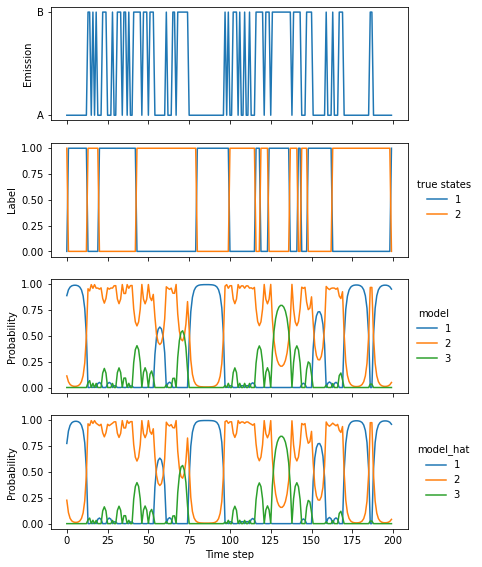

In [282]:
xs, ys = data[0]
fbs = model.forward_backward(ys)
fbs_hat = model_hat.forward_backward(ys)

fig, axs = plt.subplots(4, 1, figsize=(6.4, 9.6), sharex=True)

axs[0].plot(ys)
for state, line in sorted(lines.items()):
    axs[1].plot(line, label=state)
for state, line in sorted(fbs.items()):
    axs[2].plot(line, label=state)
for state, line in sorted(fbs_hat.items()):
    axs[3].plot(line, label=state)
axs[3].set_xlabel('Time step')
axs[0].set_ylabel('Emission')
axs[1].set_ylabel('Label')
axs[2].set_ylabel('Probability')
axs[3].set_ylabel('Probability')
axs[1].legend(title='true states', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
axs[2].legend(title='model', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
axs[3].legend(title='model_hat', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

The posterior decoding curves are effectively identical. There are, of course, some minor differences but no real patterns that I can see. Generally these models are good at detecting the time steps corresponding to state 1 but much worse at distinguishing between states 2 and 3. We can understand this qualitatively by examining the original model parameters. State 1 is highly "sticky" and only emits As, so long runs of As are extremely likely to correspond to state 1. State 3 only emits Bs, but it's fairly likely to switch to state 2. Since state 2 is equally likely to emit an A as a B, it's difficult to know if a B was emitted because the model remained in state 3 or because it switched to state 2. This shows that state inference can be highly variable even if the parameters are known exactly.

#### 2.3.2 Discrete emission distribution

For the next example, we'll derive and implement the MLE for the rate of a *Poisson distribution*. Poisson distributions are commonly used to model count data with no upper bound. The underlying assumptions are the counts represent events that occur with some fixed average rate over time and the number of events in one interval is independent of the number of events in any other non-overlapping interval. These conditions impose few restrictions, so Poisson distributions are used to model a variety of phenomena, ranging from the number of particle decays in a radioactive sample to the number of requests arriving at a web server.

If the events of a Poisson process $X$ occur at an average rate of $\lambda$, then the probability that $x$ events are observed in an interval of length $t$ is given by

$$
\begin{aligned}
P(X = x | \lambda, t)
&= f(x, \lambda, t) \\
&= e^{-\lambda t} \frac{(\lambda t)^x}{x!}. \\
\end{aligned}
$$

The rate $\lambda$ and length of the interval $t$ always appear as the product $\lambda t$, so Poisson distributions are often parametrized in terms of $\lambda$ only. Confusingly, this is often still called a rate even though it is technically a unitless quantity. To match these conventions, I'll also drop $t$ as a parameter, although I'll avoid referring to $\lambda$ as a rate.

We can now write the log-likelihood function explicitly:

$$
\begin{aligned}
L(\lambda)
&= \sum_{i=1}^N \log f(x_i, \lambda) \\
&= \sum_{i=1}^N \log \left( e^{-\lambda} \frac{\lambda^x_i}{x_i!} \right) \\
&= \sum_{i=1}^N -\lambda + x_i \log \lambda - \log (x_i!) \\
&= -N\lambda + \sum_{i=1}^N x_i \log \lambda - \log (x_i!). \\
\end{aligned}
$$

To find the MLE for $\lambda$, we 1) take the derivative relative to $\lambda$ and 2) solve for $\lambda$ when this expression is zero. In the second step, we're solving for specific values where the derivative is zero, so we'll replace $\lambda$ with $\hat{\lambda}$ to clarify this distinction.

**Step 1: Differentiate the log-likelihood function**
$$
\begin{aligned}
\frac{dL(\lambda)}{d\lambda}
&= -N + \sum_{i=1}^N \frac{x_i}{\lambda} \\
\end{aligned}
$$

**Step 2: Solve for the MLE**
$$
\begin{aligned}
0 &= -N + \sum_{i=1}^N \frac{x_i}{\hat{\lambda}} \\
N &= \frac{\sum_{i=1}^N x_i}{\hat{\lambda}} \\
\hat{\lambda} &= \frac{\sum_{i=1}^N x_i}{N} = \bar{x} \\
\end{aligned}
$$

Pleasingly, the MLE for $\lambda$ is the sample average. Now let's implement this in code using a model with two arbitrary states. This will follow the same format as the previous section beginning with creating some simulated data, so I'll proceed with little comment.

In [283]:
t_dists = {1: {1: 0.95, 2: 0.05},
           2: {1: 0.25, 2: 0.75}}
e_dists = {1: stats.poisson(3),
           2: stats.poisson(0.5)}
start_dist = {1: 0.5, 2: 0.5}

model = homomorph.HMM(t_dists=t_dists, e_dists=e_dists, start_dist=start_dist)

data = [model.simulate(200, random_state=i) for i in range(10)]  # Use a different random seed for each example
data = [list(zip(*example)) for example in data]

The estimate for each state's $\lambda$ is simply the average of the emissions associated with that state. However, the emissions are separated across multiple examples and not organized by state, so we'll first gather them in a dictionary keyed by state and then take the average.

In [284]:
# Make emission dicts keyed by state
state2emits = {}
for state in t_dists:
    state2emits[state] = []

# Add emissions
for example in data:
    xs, ys = example
    for state, emit in zip(xs, ys):
        state2emits[state].append(emit)

# Average emissions
lambda_hats = {}
for state, emits in state2emits.items():
    lambda_hat = sum(emits) / len(emits)
    lambda_hats[state] = lambda_hat
lambda_hats

{1: 2.991077119184194, 2: 0.46635730858468677}

Though the parameter estimates are convenient for inspection, discrete emission distributions over an infinite domain are implemented as SciPy random variables in Homomorph.

In [285]:
e_dists_hat = {state: stats.poisson(lambda_hat) for state, lambda_hat in lambda_hats.items()}

The estimators for the transition and start distributions are the same, so we can copy those cells from the previous example.

In [286]:
# Make transition count dicts and add pseudocounts
t_pseudo = 0.1
t_counts = {}
for state1, t_dist in t_dists.items():
    t_count = {}
    for state2 in t_dist:
        t_count[state2] = t_pseudo
    t_counts[state1] = t_count

# Add observed counts
for example in data:
    xs, ys = example
    state0 = xs[0]
    for state1 in xs[1:]:
        t_counts[state0][state1] += 1
        state0 = state1

# Normalize counts
t_dists_hat = {}
for state1, t_count in t_counts.items():
    t_sum = sum(t_count.values())
    t_dist_hat = {}
    for state2, count in t_count.items():
        t_dist_hat[state2] = count / t_sum
    t_dists_hat[state1] = t_dist_hat
t_dists_hat

{1: {1: 0.9487589559877175, 2: 0.0512410440122825},
 2: {1: 0.19452247191011232, 2: 0.8054775280898876}}

In [287]:
# Make start count dicts and add pseudocounts
start_pseudo = 0.1
start_count = {}
for state in start_dist:
    start_count[state] = start_pseudo

# Add observed counts
for example in data:
    xs, ys = example
    start_count[xs[0]] += 1

# Normalize counts
start_sum = sum(start_count.values())
start_dist_hat = {}
for state, count in start_count.items():
    start_dist_hat[state] = count / start_sum
start_dist_hat

{1: 0.303921568627451, 2: 0.696078431372549}

With the parameter estimates in hand, we can instantiate an estimated model and compare the decoded states to those from the actual model and the true states.

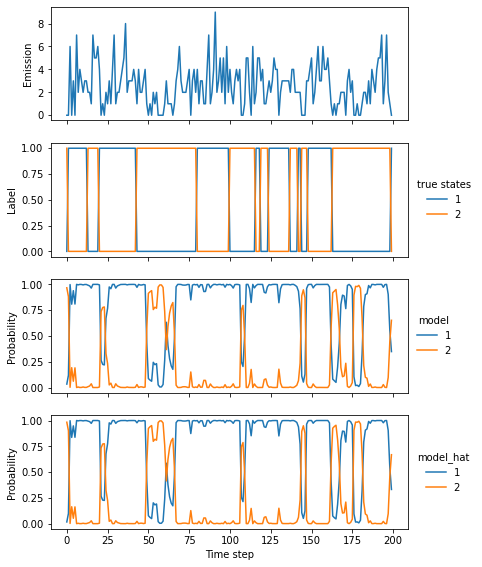

In [288]:
model_hat = homomorph.HMM(t_dists=t_dists_hat, e_dists=e_dists_hat, start_dist=start_dist_hat)

xs, ys = data[0]
fbs = model.forward_backward(ys)
fbs_hat = model_hat.forward_backward(ys)

fig, axs = plt.subplots(4, 1, figsize=(6.4, 9.6), sharex=True)

axs[0].plot(ys)
for state, line in sorted(lines.items()):
    axs[1].plot(line, label=state)
for state, line in sorted(fbs.items()):
    axs[2].plot(line, label=state)
for state, line in sorted(fbs_hat.items()):
    axs[3].plot(line, label=state)
axs[3].set_xlabel('Time step')
axs[0].set_ylabel('Emission')
axs[1].set_ylabel('Label')
axs[2].set_ylabel('Probability')
axs[3].set_ylabel('Probability')
axs[1].legend(title='true states', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
axs[2].legend(title='model', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
axs[3].legend(title='model_hat', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

#### 2.3.3 Continuous emission distribution

The normal distribution, with its iconic bell-shaped density curve, is practically synonymous with statistics. This association is deserved as the normal distribution underlies many foundational results and methods in both mathematical and applied statistics. For our purposes, however, we only need to know that the normal distribution is a common and robust model for continuous measurements, so in this example we'll derive the MLEs for its parameters.

As you saw in the previous example, once the MLEs are derived, the implementations are often a straightforward translation from mathematical symbols to code. In fact, for many common distributions, including the normal distribution, the MLEs have closed-form expressions that can be interpreted in terms of familiar statistical quantities like the mean or variance. Thus, for this example I'll skip the implementations and only present the derivation.

Let's first review the pdf of a normal distribution:

$$
f(x, \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left( x-\mu \right)^2}{2\sigma^2}}.
$$

Though the expression may look intimidating, the important take-away is the distribution has two parameters $\mu$ and $\sigma^2$, which are equal to its mean and variance, respectively. In qualitative terms, $\mu$ controls the position of the peak of the curve and $\sigma^2$ controls its width.

We will now substitute the density into the log-likelihood function:

$$
\begin{aligned}
L(\mu, \sigma^2)
&= \sum_{i=1}^N \log f(x_i, \lambda) \\
&= \sum_{i=1}^N -\frac{1}{2}\log(2\pi) - \frac{1}{2}\log(\sigma^2) - \frac{\left( x_i-\mu \right)^2}{2\sigma^2} \\
&= -\frac{N}{2}\log(2\pi) - \frac{N}{2}\log(\sigma^2) - \sum_{i=1}^N \frac{\left( x_i-\mu \right)^2}{2\sigma^2}. \\
\end{aligned}
$$

As the pdf has two parameters, $\mu$ and $\sigma^2$, the log-likelihood is a function of these variables. This changes the next step slightly from the previous example since we have to take the partial derivative relative to each and solve the resulting system of equations. In this case the algebra works out nicely, but sometimes numerical optimization techniques are required.

We'll start with the partial derivative for $\mu$. A subtle point for distributions with multiple parameters is in the second step when the derivative is set to zero, we replace each parameter with its estimated counterpart since we're solving for specific points where the derivatives relative to each parameter are simultaneously zero.

**Step 1: Differentiate the log-likelihood function**
$$
\begin{aligned}
\frac{\partial L}{\partial \mu}
&= \sum_{i=1}^N \frac{\left( x_i- \mu \right)}{\sigma^2} \\
\end{aligned}
$$

**Step 2: Solve for the MLE**
$$
\begin{aligned}
0 &= \sum_{i=1}^N \frac{\left( x_i- \hat{\mu} \right)}{\hat{\sigma}^2} \\
N\hat{\mu} &= \sum_{i=1}^N x_i \\
\hat{\mu} &= \frac{\sum_{i=1}^N x_i}{N} = \bar{x} \\
\end{aligned}
$$

Now let's find the MLE for $\sigma^2$. Another subtle point for the normal distribution in particular is the derivative is taken relative to the variance, $\sigma^2$, not the standard deviation, $\sigma$. Though this choice does not impact the resulting formula, it both simplifies the calculation and reflects the natural role of the variance as the more "fundamental" statistical quantity.

**Step 1: Differentiate the log-likelihood function**
$$
\begin{aligned}
\frac{\partial L}{\partial \sigma^2}
&= -\frac{N}{2\sigma}^2 + \sum_{i=1}^N \frac{\left( x_i- \mu \right)^2}{2\sigma^4} \\
\end{aligned}
$$

**Step 2: Solve for the MLE**
$$
\begin{aligned}
0 &= -\frac{N}{2\hat{\sigma}^2} + \sum_{i=1}^N \frac{\left( x_i- \hat{\mu} \right)^2}{2\hat{\sigma}^4} \\
\frac{N}{\hat{\sigma}^2} &= \sum_{i=1}^N \frac{\left( x_i- \hat{\mu} \right)^2}{\hat{\sigma}^4} \\
{\hat{\sigma}^2} &= \frac{\sum_{i=1}^N \left( x_i- \hat{\mu} \right)^2}{N} \\
\end{aligned}
$$

As I hinted in the introduction for this section, the MLEs for $\mu$ and $\sigma^2$ are simply the mean and variance! Notice the MLE for $\sigma^2$ includes $\hat{\mu}$, so in practice we would calculate $\hat{\mu}$ first and substitute that value in the expression for $\hat{\sigma}^2$. Those with some background in statistics might notice the formula for $\hat{\sigma}^2$ has a factor of $N$ rather than $N-1$ in the denominator. This is no typo. It turns out that while MLEs are optimal in many ways, they are not always unbiased, meaning they can have tendency to be higher or lower than the true value. In this case, the MLE for $\sigma^2$ is low by a factor of exactly $\frac{N-1}{N}$ on average, so some formulas divide by this quantity to remove the bias. This actually makes our estimate more imprecise, so there are some trade-offs involved in using one formula over the other. The good news is the difference is trivial for most data sets of realistic size, so the choice is largely inconsequential.

## 3 Training with unknown states

### 3.1 Estimation-maximization, informally

When we knew the states, we could assign each emission to a log-likelihood function and optimize the parameters of these functions separately. However, when the states are unknown, the problem of estimating parameters is much harder because we can't decompose the log-likelihood into independent terms. (We'll see this formally in the next section.) Not all hope is lost though. Remember that we can estimate parameters when we know the states, and when we know parameters we can estimate state probabilities. While this may seem like a chicken and egg problem, we can use this relationship as an iterative method for estimating parameters when the states are unknown. In practice, it works as the following:

1. Make an informed guess of the initial parameters.
2. Use the current parameters to estimate posterior state probabilities.
3. Use the posterior state probabilities to improve the parameter estimates.
4. Repeat steps 2 and 3 a fixed number of times or until some convergence criteria is met.

In the context of HMMs, this procedure is known as the *Baum-Welch algorithm*, but it's a special case of a more general technique called *estimation-maximization* (EM). Though it intuitively makes sense, it's not at all clear that it will work in practice. For example, the likelihood function could ping-pong up and down without ever settling down to a single value. Fortunately, each iteration is guaranteed to improve the likelihood. Unfortunately, the sequence may converge to a local rather than a global maximum, *i.e.* a good answer but not necessarily the best. Thus, it's common to run the algorithm multiple times with different initial parameters and choose the final parameters as those with the largest likelihood.

Hopefully this discussion has given you a conceptual overview of the Baum-Welch algorithm. Clearly we've skipped many details, so in the next section we'll implement it from scratch for categorical distributions. Then in the following sections, we'll introduce the EM algorithm formally and use it to derive the update equations for a normal distribution.

### 3.2 Implementing Baum-Welch for categorical distributions

The steps in the Baum-Welch algorithm as I've presented it above should at this point make sense except step 3. How exactly do we use posterior decoding to improve the parameter estimates? For a generic distribution, we'll need the EM formalism to derive the update equations properly, but for a categorical distribution we can intuit our way to the answer. We'll start with the transition distributions since I've already introduced their MLEs, but then we'll derive a similar result for the emission distributions. Recall that the MLEs for the parameters of a transition distribution are written in terms of the number of observed transitions between states $i$ and $j$, $n_{ij}$:

$$
\hat{a}_{ij} = \frac{n_{ij}}{\sum_{j=1}^S n_{ij}}.
$$

Unfortunately, we don't have access to these counts since the states are unknown. However, what if we replaced these counts with how often we thought they happened under our current parameter estimates? For example, if between time $t$ and $t+1$, we calculate there's a 75% chance the process remained in state 1 and a 25% chance it transitioned to state 2, that's effectively a 0.75 count towards $n_{11}$ and a 0.25 count towards $n_{12}$. Although we originally defined the $n_{ij}$ variables in terms of whole numbers, the equations still yield valid estimates with fractional counts.

Now the name of the game is to calculate these probabilities over all time steps. Formally we're looking for:

$$
\begin{aligned}
n_{ij}
&= \sum_{t=1}^{T-1} P(X_t=i, X_{t+1}=j|Y=y, \Theta) \\
&= \frac{1}{P(Y=y|\Theta)}
   \sum_{t=1}^{T-1} P(X_t=i, X_{t+1}=j, Y=y|\Theta) \\
&= \frac{1}{P(Y=y|\Theta)}
   \sum_{t=1}^{T-1} P(X_t=i, Y_1=y_1, \ldots, Y_t=y_t|\Theta)
                    P(X_{t+1}=j, Y_{t+1}=y_{t+1}, \ldots, Y_T=y_T|X_t=i, Y_1=y_1, \ldots, Y_t=y_t, \Theta) \\
&= \frac{1}{P(Y=y|\Theta)}
   \sum_{t=1}^{T-1} P(X_t=i, Y_1=y_1, \ldots, Y_t=y_t|\Theta)
                    P(X_{t+1}=j, Y_{t+1}=y_{t+1}, \ldots, Y_T=y_T|X_t=i, \Theta). \\
\end{aligned}
$$

The first term is the forward variable evaluated at time $t$ and state $i$, which we'll denote by $f_i(t)$. I haven't formally introduced this quantity in this tutorial, but we can easily obtain these values with the `forward` method of an `HMM` instance. Incidentally, $P(Y=y|\Theta)=\sum_i f_i(T)$ since this sums the probability of the entire emission sequence over all possible final states. Let's now focus on the second term in the sum and define the following events to clean up the notation:

- $A: Y_{t+2}=y_{t+2}, \ldots, Y_T=y_t$
- $B: Y_{t+1}=y_{t+1}$
- $C: X_{t+1}=j$
- $D: X_t=i$.

Thus, we have

$$
\begin{aligned}
P(X_{t+1}=j, Y_{t+1}=y_{t+1}, \ldots, Y_T=y_T|X_t=i, \Theta)
&= P(A, B, C|D, \Theta) \\
&= P(A|B, C, D, \Theta) \cdot P(B|C, D, \Theta) \cdot P(C|D, \Theta) \\
&= P(A|C, \Theta) \cdot P(B|C, \Theta) \cdot P(C|D, \Theta). \\
\end{aligned}
$$

From right to left, the third term is $a_{ij}$, the second term is $e_j(y_{t+1})$, and the first term is the backward variable evaluated at time $t+1$ and state $j$, which we'll denote by $b_j(t+1)$. Analogous to the forward variable, the backward variable is available via the `backward` method of an `HMM` instance.

Putting everything together we have

$$
n_{ij} = \frac{1}{P(Y=y|\Theta)} \sum_{t=1}^{T-1} f_i(t)a_{ij}e_j(y_{t+1})b_j(t+1).
$$

Now let's tackle the emission distributions. When the states are known, the MLEs are the same, but instead of counting transitions between states, we count emissions. (The emissions essentially take on the role of the "target" state $j$.) When the states are unknown, we replace these counts with how much we think each state is responsible for each emission. In other words, if at time $t$ we observe emission $i$ and we calculate an 90% chance of state 1 and a 10% chance of state 2, we assign a 0.9 count towards $n_{1i}$ and a 0.1 count towards $n_{2i}$. Written mathematically,

$$
\begin{aligned}
n_{ij}
&= \sum_{t: y_t=j} P(X_t=i|Y=y, \Theta) \\
&= \frac{1}{P(Y=y|\Theta)}
   \sum_{t: y_t=j} P(X_t=i, Y=y|\Theta) \\
&= \frac{1}{P(Y=y|\Theta)}
   \sum_{t: y_t=j} P(Y_1=y_1, \ldots, Y_t=y_t, X_t=i|\Theta)
                   P(Y_{t+1}=y_{t+1}, \ldots, Y_T=y_T| X_t=i, \Theta) \\
&= \frac{1}{P(Y=y|\Theta)}
   \sum_{t: y_t=j} f_i(t)b_i(t). \\
\end{aligned}
$$

With these results, we can implement the Baum-Welch algorithm. We'll use the same example from the MLE section, so we can compare the performance of the two methods.

In [289]:
t_dists = {1: {1: 0.95, 2: 0.05},
           2: {1: 0.05, 2: 0.9, 3: 0.05},
           3: {2: 0.35, 3: 0.65}}
e_dists = {1: {'A': 1},
           2: {'A': 0.5, 'B': 0.5},
           3: {'B': 1}}
start_dist = {1: 0.2, 2: 0.5, 3: 0.3}

model = homomorph.HMM(t_dists=t_dists, e_dists=e_dists, start_dist=start_dist)

data = [model.simulate(200, random_state=i) for i in range(10)]  # Use a different random seed for each example
data = [list(zip(*example)) for example in data];

To start the algorithm, we first need a model structure and initial estimates for its parameters. To keep things comparable with the previous example, we'll assume we know the disallowed transitions but not the disallowed emissions. Though I'll use uniform random values for the initial pseudocounts to keep the code simple, you may want to use specific distributions for each. Additionally, while it's good practice to use the best result from several different random initializations, if you do choose to hard code the initial parameters, you must ensure the states are different from each other in some way. If the states are all identical, there's no way for the model to "break symmetry," and all the updates will yield parameters that are the same as the initial ones.

In [290]:
random.seed(1)

# Make transition count dicts and add pseudocounts
t_counts = {}
for state1, t_dist in t_dists.items():
    t_count = {}
    for state2 in t_dist:
        t_count[state2] = random.random()
    t_counts[state1] = t_count

# Normalize counts
t_dists_hat = {}
for state1, t_count in t_counts.items():
    t_sum = sum(t_count.values())
    t_dist_hat = {}
    for state2, count in t_count.items():
        t_dist_hat[state2] = count / t_sum
    t_dists_hat[state1] = t_dist_hat
t_dists_hat

{1: {1: 0.13685528663315571, 2: 0.8631447133668443},
 2: {1: 0.5043817911017634, 2: 0.16844258615115162, 3: 0.3271756227470851},
 3: {2: 0.4082259386891194, 3: 0.5917740613108805}}

In [291]:
random.seed(2)

# Collect all possible emissions
e_set = set()
for example in data:
    xs, ys = example
    e_set.update(ys)

# Make emission count dicts and add pseudocounts
e_counts = {}
for state in t_dists:
    e_counts[state] = {emit: random.random() for emit in e_set}

# Normalize counts
e_dists_hat = {}
for state, e_count in e_counts.items():
    e_sum = sum(e_count.values())
    e_dist_hat = {}
    for emit, count in e_count.items():
        e_dist_hat[emit] = count / e_sum
    e_dists_hat[state] = e_dist_hat
e_dists_hat

{1: {'A': 0.5021552995618842, 'B': 0.49784470043811585},
 2: {'A': 0.39987288219487493, 'B': 0.6001271178051251},
 3: {'A': 0.531667470841593, 'B': 0.4683325291584069}}

In [292]:
random.seed(3)

# Make start count dicts and add pseudocounts
start_count = {}
for state in start_dist:
    start_count[state] = random.random()

# Normalize counts
start_sum = sum(start_count.values())
start_dist_hat = {}
for state, count in start_count.items():
    start_dist_hat[state] = count / start_sum
start_dist_hat

{1: 0.2065397992628295, 2: 0.47236009956297115, 3: 0.32110010117419935}

Let's now code the main loop. Mathematically we can define convergence when the improvements in the log-likelihood are below some threshold, `epsilon`. In practice, this may take too long, so we'll also define a maximum number of iterations, `maxiter`. What follows is a fairly straightforward implementation of the equations we derived previously. There are two nuanced points, however. First, to preserve the model structure, the counts are always taken over the allowed transitions or emissions. (In theory, disallowed transitions or emissions should always have a probability of zero, but floating point errors may yield unexpected results.) Second, the forward and backward variables are scaled to sum to 1 at each time step for numerical stability. Thus, the true value at time $t$ is a product of the raw value and all the scaling factors up to and including time $t$. (Since the backward variable is calculated recursively from the final instead of the first observation, the product is taken from $t$ to to $T$.) A side effect of this representation is $P(Y=y|\Theta)$ is simply the product of all scaling factors.

In [293]:
epsilon = 0.01
maxiter = 100

ll0 = None
model_hat = homomorph.HMM(t_dists=t_dists_hat, e_dists=e_dists_hat, start_dist=start_dist_hat)
for numiter in range(maxiter):
    # Initialize count dictionaries
    ps = []
    t_counts = {state1: {state2: 0 for state2 in t_dist} for state1, t_dist in t_dists_hat.items()}
    e_counts = {state: {emit: 0 for emit in e_dist} for state, e_dist in e_dists_hat.items()}
    start_count = {state: 0 for state in start_dist_hat}
    
    # Get counts across all examples
    for example in data:
        xs, ys = example
        fs, ss_f = model_hat.forward(ys)
        bs, ss_b = model_hat.backward(ys)
        
        p = reduce(lambda x, y: x+y, map(log, ss_f))
        ss_f = list(accumulate(map(log, ss_f)))
        ss_b = list(accumulate(map(log, ss_b[::-1])))[::-1]
        ps.append(p)
        
        # t_counts
        for t in range(len(ys)-1):
            for state1, t_count in t_counts.items():
                for state2 in t_count:
                    count = fs[state1][t]*t_dists_hat[state1][state2]*e_dists_hat[state2][ys[t+1]]*bs[state2][t+1]
                    t_count[state2] += count * exp(ss_f[t] + ss_b[t+1] - p)
        
        # e_counts
        for t in range(len(ys)):
            for state, e_count in e_counts.items():
                if ys[t] in e_count:
                    count = fs[state][t]*bs[state][t]
                    e_count[ys[t]] += count * exp(ss_f[t] + ss_b[t] - p)
        
        # start_count
        for state in start_count:
            count = fs[state][0]*bs[state][0]
            start_count[state] += count * exp(ss_f[0] + ss_b[0] - p)
        
    # Format parameters for display
    t_string = pprint.pformat(t_dists_hat).replace('\n', '\n' + len('t_dists: ')*' ')
    e_string = pprint.pformat(e_dists_hat).replace('\n', '\n' + len('e_dists: ')*' ')
    start_string = pprint.pformat(start_dist_hat)
    
    # Check stop condition
    # Don't want to repeat calculations, so ith iterate checks previous update
    # For example, 0th iterate shows initial parameters and 1st iterate shows results of first update
    ll = sum(ps)
    if ll0 is not None and abs(ll - ll0) < epsilon:
        print(f'FINAL VALUES')
        print('log-likelihood:', ll)
        print('Δlog-likelihood:', ll-ll0 if ll0 is not None else None)
        print('t_dists:', t_string)
        print('e_dists:', e_string)
        print('start_dist:', start_string)
        break
    
    # Print results
    print(f'ITERATION {numiter}')
    print('log-likelihood:', ll)
    print('Δlog-likelihood:', ll-ll0 if ll0 is not None else None)
    print('t_dists:', t_string)
    print('e_dists:', e_string)
    print('start_dist:', start_string)
    print()
    
    # Normalize all counts and update model
    t_dists_hat = {}
    for state1, t_count in t_counts.items():
        t_sum = sum(t_count.values())
        t_dist_hat = {}
        for state2, count in t_count.items():
            t_dist_hat[state2] = count / t_sum
        t_dists_hat[state1] = t_dist_hat
    
    e_dists_hat = {}
    for state, e_count in e_counts.items():
        e_sum = sum(e_count.values())
        e_dist_hat = {}
        for emit, count in e_count.items():
            e_dist_hat[emit] = count / e_sum
        e_dists_hat[state] = e_dist_hat
    
    start_sum = sum(start_count.values())
    start_dist_hat = {}
    for state, count in start_count.items():
        start_dist_hat[state] = count / start_sum
    
    ll0 = ll
    model_hat = homomorph.HMM(t_dists=t_dists_hat, e_dists=e_dists_hat, start_dist=start_dist_hat)

ITERATION 0
log-likelihood: -1438.7779688313935
Δlog-likelihood: None
t_dists: {1: {1: 0.13685528663315571, 2: 0.8631447133668443},
          2: {1: 0.5043817911017634, 2: 0.16844258615115162, 3: 0.3271756227470851},
          3: {2: 0.4082259386891194, 3: 0.5917740613108805}}
e_dists: {1: {'A': 0.5021552995618842, 'B': 0.49784470043811585},
          2: {'A': 0.39987288219487493, 'B': 0.6001271178051251},
          3: {'A': 0.531667470841593, 'B': 0.4683325291584069}}
start_dist: {1: 0.2065397992628295, 2: 0.47236009956297115, 3: 0.32110010117419935}

ITERATION 1
log-likelihood: -1221.9071519611223
Δlog-likelihood: 216.87081687027126
t_dists: {1: {1: 0.1403639149863444, 2: 0.8596360850136555},
          2: {1: 0.48866782131196673, 2: 0.15862358863963363, 3: 0.3527085900483996},
          3: {2: 0.36877189880344846, 3: 0.6312281011965516}}
e_dists: {1: {'A': 0.6838887251119121, 'B': 0.3161112748880879},
          2: {'A': 0.639592667466483, 'B': 0.3604073325335171},
          3: {'A': 

ITERATION 15
log-likelihood: -906.5027065412397
Δlog-likelihood: 0.09177825686413144
t_dists: {1: {1: 0.1973082310002196, 2: 0.8026917689997803},
          2: {1: 0.7288022081244135, 2: 0.16909222026380297, 3: 0.10210557161178345},
          3: {2: 0.04630406727510239, 3: 0.9536959327248976}}
e_dists: {1: {'A': 0.2740132111366285, 'B': 0.7259867888633715},
          2: {'A': 0.49623009986425803, 'B': 0.5037699001357419},
          3: {'A': 0.9998569499069642, 'B': 0.00014305009303576725}}
start_dist: {1: 0.7301326293752537, 2: 0.0657454956412801, 3: 0.20412187498346612}

ITERATION 16
log-likelihood: -906.433548527001
Δlog-likelihood: 0.06915801423872381
t_dists: {1: {1: 0.19670334546756876, 2: 0.8032966545324312},
          2: {1: 0.7291052394213323, 2: 0.16913505468316356, 3: 0.101759705895504},
          3: {2: 0.046170227286577895, 3: 0.9538297727134222}}
e_dists: {1: {'A': 0.2765258153615573, 'B': 0.7234741846384427},
          2: {'A': 0.4942254026846651, 'B': 0.505774597315335},


Based on the results, the algorithm seems to have merged states 2 and 3 into a single state that emits a mixture of A and B. State 1 was largely estimated correctly, but it's labeled as state 3 in the estimated model. There are two possible reasons why this happened. First, the initial values are bad. We chose them randomly, so maybe we were unlucky, and there was a "bad" local maximum near those initial values. Additionally, since we didn't prime the initial values with any information that state 1 only emits A and state 3 only emits B, the algorithm exchanged them. For both these reasons, it's best practice to use multiple initializations that are random but still encode the expected behavior for each state. Try playing around with different random seeds or initialization schemes to see if the fit improves!

The second reason why the algorithm merged states 2 and 3 is state 2 is inherently difficult to fit. Under the current parameters, state 2 is just as likely to emit an A as a B, which maximizes the uncertainty associated with its emissions. (Compare this to states 1 or 3 whose emissions we know with certainty.) While this example is highly artificial, it illustrates that although we can define an HMM however we like, its emission distribution may be well-described by multiple sets of parameters, *i.e.*, the likelihood surface is broad and flat or has multiple peaks.

### 3.3 Estimation-maximization, formally

Though what we've done so far makes sense intuitively, let's look at what's happening more formally, so we can generalize this approach to other emission distributions. Recall that in maximum likelihood estimation, we find parameters $\hat{\Theta}$ that maximize the logarithm of probability of the data, $D$:

$$
\begin{aligned}
\hat{\Theta}
&= \argmax_\Theta L(\Theta) \\
&= \argmax_\Theta \log P(D|\Theta). \\
\end{aligned}
$$

In the HMM setting with known states, the data are composed of $N$ examples of ordered pairs $\{(x_i, y_i)|1 \le i \le N\}$ where $x_i$ is a sequence of states and $y_i$ is a sequence of emissions, each with length $T_i$. For simplicity, however, we'll only consider a single example $(x, y)$ where $x_t$ and $y_t$ indicate the $t$th state and emission in those sequences, respectively. We can then write the log-likelihood function as $L(\Theta) = \log P(X=x, Y=y|\Theta)$. So far this is all review from the previous section. What about the case when we only know the emissions, $y$? Then the log-likelihood is $L(\Theta) = \log P(Y=y|\Theta)$. Though we can calculate this quantity directly with the forward algorithm and thus in principle apply a number of optimization algorithms, we'll instead take a probabilistic approach and write the log-likelihood function as a sum over all possible state sequences:

$$
\begin{aligned}
L(\Theta)
&= \log P(Y=y|\Theta) \\
&= \log \sum_x P(Y=y, X=x|\Theta). \\
\end{aligned}
$$

The only problem is that for an emission sequence of length $T$ and a model with $S$ hidden states, there are $S^T$ possible state sequences. This sum has an exponential number of terms and is therefore intractable for any data of realistic size.

Thus, this expression hasn't gotten us anywhere yet. However, it is possible to derive a related but more tractable quantity whose improvements lower bound improvements for the log-likelihood. This quantity, commonly denoted as $Q(\Theta|\Theta_n)$, is defined as the expectation of the log-likelihood function with respect to the conditional distribution of the states $X$ given the emissions $y$:

$$
\begin{aligned}
Q(\Theta|\Theta_n)
&= E_{X|Y=y,\Theta_n} \log P(Y=y, X|\Theta) \\
&= \sum_x P(X=x|Y=y, \Theta_n) \log P(Y=y, X=x|\Theta). \\
\end{aligned}
$$

This is a confusing expression, especially since the notation for conditional expectation is dense. However, in the second line I've explicitly written the expectation as a sum, which will hopefully clarify what's happening. We have a sum of the joint log-likelihoods of the states and emissions given the parameters (the $\log P(Y=y, X=x|\Theta$ term) where each term in the sum is weighted by the quantity $P(X=x|Y=y, \Theta_n)$. Notice that $P(X=x|Y=y, \Theta_n)$ is constant for a given $\Theta_n$, so $Q(\Theta|\Theta_n)$ is function only of the log-likelihood terms.

Next we define the new estimates of the parameters as

$$
\Theta_{n+1} = \argmax_\Theta Q(\Theta|\Theta_n).
$$

These two steps are where the name expectation-maximization is derived since the first is the calculation of an expectation, and the second is a maximization of that expectation. It may seem like we haven't done much to simplify the problem since we're still dealing with sums over all state sequences. However, by moving the sum outside the logarithm, we've greatly simplified the maximization step as we will see in the next section.

By repeating this process, we can iteratively improve our estimates of the parameters. I told you that these improvements in $Q(\Theta|\Theta_n)$ lower bound improvements in the log-likelihood. I won't show the derivation here, but what I mean by this is

$$
\log P(Y|\Theta) - \log P(Y|\Theta_n) \ge Q(\Theta|\Theta_n) - Q(\Theta_n|\Theta_n).
$$

Since in each step we maximize $Q(\Theta|\Theta_n)$, the right quantity is always non-negative. Thus, the log-likelihood of the emissions is improved by at least that much as well. Written mathematically,

$$
Q(\Theta_{n+1}|\Theta_n) - Q(\Theta_n|\Theta_n) \ge 0
\implies
\log P(Y|\Theta_{n+1}) - \log P(Y|\Theta_n) \ge 0.
$$

### 3.4 Deriving the update equations for a normal distribution

We'll now apply this theory to the HMM context. First we'll show not only that $Q(\Theta|\Theta_n)$ is tractable to calculate but also that it decomposes into independent terms. Then we'll show how to derive the update equations for normal emission distributions. Let's get started!

We first expand the expression for $Q(\Theta|\Theta_n)$ using the probabilistic structure of an HMM:

$$
\begin{aligned}
Q(\Theta|\Theta_n)
= &\sum_x P(X=x|Y=y, \Theta_n) \log P(Y=y, X=x|\Theta) \\
= &\sum_x P(X=x|Y=y, \Theta_n)
          \log \left[P(Y_1=y_1|X_1=x_1, \Theta)P(X_1=x_1|\Theta)
                      \prod_{t=1}^{T-1} P(Y_{t+1}=y_{t+1}|X_{t+1}=x_{t+1}, \Theta)P(X_{t+1}=x_{t+1}|X_t=x_t, \Theta)
               \right] \\
= &\sum_x P(X=x|Y=y, \Theta_n)
          \left[\log P(X_1=x_1|\Theta) +
                \sum_{t=1}^T \log P(Y_t=y_t|X_t=x_t, \Theta) +
                \sum_{t=1}^{T-1} \log P(X_{t+1}=x_{t+1}|X_t=x_t, \Theta)
          \right] \\
= &\sum_i P(X_1=i|Y=y, \Theta_n) \log P(X_1=i|\Theta) \\
  &+ \sum_i \sum_{t=1}^T P(X_t=i|Y=y, \Theta_n) \log P(Y_t=y_t|X_t=i, \Theta) \\
  &+ \sum_{i, j} \sum_{t=1}^{T-1} P(X_t=i, X_{t+1}=j|Y=y, \Theta_n) \log P(X_{t+1}=j|X_t=i, \Theta). \\
\end{aligned}
$$

In the final step, the outer sum was distributed over each term and exchanged with the inner sum. I'll show this step explicitly below for the second term:

$$
\begin{aligned}
\sum_x P(X=x|Y=y, \Theta_n) \sum_{t=1}^T \log P(Y_t=y_t|X_t=x_t, \Theta)
&= \sum_x \sum_{t=1}^T P(X=x|Y=y, \Theta_n) \log P(Y_t=y_t|X_t=x_t, \Theta) \\
&= \sum_i \sum_{x \setminus x_t} \sum_{t=1}^T P(X=x|Y=y, \Theta_n) \log P(Y_t=y_t|X_t=i, \Theta) \\
&= \sum_i \sum_{t=1}^T \log P(Y_t=y_t|X_t=i, \Theta) \sum_{x \setminus x_t} P(X=x|Y=y, \Theta_n) \\
&= \sum_i \sum_{t=1}^T P(X_t=i|Y=y, \Theta_n) \log P(Y_t=y_t|X_t=i, \Theta). \\
\end{aligned}
$$

(In the final line, I used that the probability of a state sequence with a fixed state $X_t=i$ is the sum of the probabilities of all state sequences that include that fixed state.)

Though moving the sum over all state sequences outside the logarithm seemed like a minor mathematical detail, it, in combination with the probabilistic structure of an HMM, makes its computation tractable. Another consequence is that if the transitions and emissions are all governed by different parameters, we can maximize the entire expression by optimizing the corresponding sum for each state or pair of states individually. You can even see that the fractional "counts" $P(X_t=i|Y=y, \Theta)$ and $P(X_t=i, X_{t+1}=j|Y=y, \Theta)$ that we defined in the previous section are the coefficients of the log-likelihood terms, which is directly related to their appearance in the update equations.

Now that we've demonstrated that each term can be optimized separately, we'll show the derivation of the update equations for a normal emission distribution. We begin by writing the term we wish to optimize for a fixed state $i$, which we'll call $q(\Theta)$:

$$
q(\Theta) = \sum_{t=1}^T P(X_t=i|Y=y, \Theta_n) \log P(Y_t=y_t|X_t=i, \Theta).
$$

We'll write $w_{it} = P(X_t=i|Y=y, \Theta_n)$ to simplify the notation and to emphasize this quantity is fixed during the maximization step. Let's also substitute the expression for a normal density with mean $\mu_i$ and variance $\sigma_i^2$:

$$
\begin{aligned}
q(\mu_i, \sigma_i^2)
&= \sum_{t=1}^T P(X_t=i|Y=y, \Theta_n) \log P(Y_t=y_t|X_t=i, \Theta) \\
&= \sum_{t=1}^T w_{it} \log \left(
                                  \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left( y-\mu \right)^2}{2\sigma^2}}
                             \right) \\
&= \sum_{t=1}^T w_{it} \left(
                             -\frac{1}{2}\log \sigma^2
                             -\frac{1}{2}\log 2\pi
                             -\frac{\left( y_t - \mu_i \right)^2}{2\sigma^2}
                       \right). \\
\end{aligned}
$$

If you've read the section on deriving the MLEs for a normal distribution, this quantity should look extremely familiar! However, let's bring it home and take some derivatives. We'll start with the parameter for the mean.

**Step 1: Differentiate the log-likelihood function**
$$
\frac{\partial q}{\partial \mu_i} = \sum_t^T w_{it} \frac{(y_t-\mu_i)}{\sigma_i^2}
$$

**Step 2: Solve for the MLE**
$$
\begin{aligned}
0 &= \sum_{t=1}^T w_{it} \frac{(y_t-\hat{\mu}_i)}{\hat{\sigma}_i^2} \\
0 &= \sum_{t=1}^T w_{it} (y_t-\hat{\mu}_i) \\
\sum_{t=1}^T w_{it} \hat{\mu}_i &= \sum_{t=1}^T w_{it} y_t \\
\hat{\mu}_i &= \frac{\sum_{t=1}^T w_{it} y_t}{\sum_{t=1}^T w_{it}} \\
\end{aligned}
$$

The resulting formula is very similar to the corresponding MLE we derived in the previous section. However, in this version each observation is multiplied by a weight, and we instead divide by the sum of the weights. (In fact, by setting the weight for each observation to one, we can recover the original formula!) Since the weights for each observation must sum to one, we've essentially partitioned each observation across all states where the amount that an observation contributes to a state is given by our confidence that it was generated by that state.

Let's now derive the update equation for the variance.

**Step 1: Differentiate the log-likelihood function**
$$
\frac{\partial q}{\partial \sigma_i^2} = \sum_{t=1}^T w_{it}
                                         \left( -\frac{1}{2 \sigma_i^2}
                                                + \frac{\left( y_t - \mu_i \right)^2}{2 \sigma_i^4}
                                         \right)
$$

**Step 2: Solve for the MLE**
$$
\begin{aligned}
0 &= \sum_{t=1}^T w_{it}
     \left( -\frac{1}{2 \hat{\sigma}_i^2}
            + \frac{\left( y_t - \hat{\mu}_i \right)^2}{2 \hat{\sigma}_i^4}
     \right) \\
\frac{1}{\hat{\sigma}_i^2} \sum_{t=1}^T w_{it} &= \frac{1}{\hat{\sigma}_i^4}
                                                  \sum_{t=1}^T w_{it} \left( y_t - \hat{\mu}_i \right)^2 \\
\hat{\sigma}_i^2 &= \frac{\sum_{t=1}^T w_{it} \left( y_t - \hat{\mu}_i \right)^2}
                         {\sum_{t=1}^T w_{it}} \\
\end{aligned}
$$

Again, the update equation has the same form as the corresponding MLE except each term in the sum is weighted. This is a common occurrence when using the EM algorithm and is a consequence of the construction of the objective function as a weighted sum of log-likelihood functions. Thus, when the MLEs are interpretible as quantities like counts or averages, the corresponding update equations are often "weighted" versions of those estimators. Of course, it's not always obvious how the weights will come into play, especially for MLEs which don't have an obvious "interpretation," so it's good idea to solve the equations yourself or look up a reference rather than guessing.

## 4 Discriminative training

In this next section, we cover discriminative training, which is sometimes called conditional maximum likelihood (CML) estimation. Technically discriminative training methods fall under the heading of training with known states since they require labeled data. However, there are enough differences in the objective function and the optimization algorithm that it deserves its own treatment. As before, the material is largely divided between a section that motivates the problem and develops the theory and a section that translates that theory into code. 

### 4.1 Discriminative training theory

Previously, we saw that maximum likelihood estimation and the EM algorithm often obtained parameter estimates which were reasonably close to their true values. However, what if we don't really care about the parameters, and we're instead more interested in using an HMM to predict the hidden states? What if the model we've chosen for our data is wrong, or, even worse, the data are so messy that no tractable statistical model could ever hope describe it?

The bad news is these all these things are frequently true when working with HMMs. While sometimes the parameters are inherently meaningful, more often than not HMMs are a tool to label data. In these cases, it's more important to get an accurate prediction of the states than an accurate estimate of the underlying parameters. If the data are actually described by the model, this distinction isn't as relevant because with enough data the parameters that yield the most accurate predictions will converge to the true parameters. However, real-world data are almost never fully described by statistical models, and in these cases the parameters that best "fit" the data are often not those that best predict the states. Furthermore, the phrase "with enough data" is actually a sneaky way of saying "as the number of observations approaches infinity," so for all practical purposes the two parameter sets are solving distinct problems.

Let's clarify these distinctions by writing them formally. Recall that in maximum likelihood estimation for HMMs with known states, we perform the following optimization:

$$
\begin{aligned}
\hat{\Theta}_{ML}
&= \argmax_\Theta L(\Theta) \\
&= \argmax_\Theta \log P(X=x, Y=y|\Theta) \\
\end{aligned}
$$

where $\Theta$ is the set of model parameters and $x$ and $y$ are sequences of states and emissions, respectively, with lengths $T$. In general, the optimization is conducted over a set of paired state and emission sequences, but since this won't change the key features of the following discussion, for simplicity we'll consider only a single state-emission sequence pair.

In contrast, conditional maximum likelihood solves the following optimization:

$$
\begin{aligned}
\hat{\Theta}_{CML}
&= \argmax_\Theta \log P(X=x|Y=y, \Theta) \\
&= \argmax_\Theta \log \frac{P(X=x, Y=y, \Theta)}{P(Y=y|\Theta)} \\
&= \argmax_\Theta \log P(X=x, Y=y, \Theta) - \log P(Y=y|\Theta). \\
\end{aligned}
$$

Notice this optimization is a slight modification of the previous, differing only by the term $-\log P(Y=y|\Theta)$. To ease the following discussion, we'll make the substitutions

$$
\log P(X=x, Y=y|\Theta) = L_c(\Theta)
$$

and

$$
\log P(Y=y|\Theta) = L_f(\Theta).
$$

$L_c$ is the joint log-likelihood of the state and emission sequences, so the term is "clamped" by the true states. $L_f$ is the log-likelihood of the emission sequences only, so the term is "free" to account for all possible state sequences. When expressed in this form, it seems a solution to the optimization should make $L_c$ as large as possible and $L_f$ as small as possible. However, $L_f \ge L_c$ for any choice of $\Theta$ because $L_f$ includes the contributions of all possible state sequences. Thus, the best we can do is to make $L_c$ as close as possible to $L_f$, and this only happens if we minimize the contribution of state sequences which are not the true sequence. In other words, conditional maximum likelihood is maximum likelihood with an added penalty for parameter choices that favor alternate state sequences.

In the maximum likelihood case, we were able to decompose the optimization into independent products under some fairly general assumptions because when the state sequence was known we only had to consider a single term. Here, however, the free term, $L_f$, forces us to consider all possible state sequences. As noted in the previous section, the number of state sequences grows exponentially with its length, so even if we were able to derive a closed-form solution, we would still have to contend with an intractable number of terms. We can't apply the EM algorithm either because this optimization doesn't depend on any hidden variables.

We'll instead take a route distinct from all the approaches we've seen so far by using a method called gradient descent. Gradient descent is the workhorse for many modern machine learning techniques, so there are numerous online resources which explain it in detail. However, the basic idea is since the derivative of a function is a measure of its response to changes in its inputs, we can use that information to iteratively improve an initial guess until we reach a minimum. For functions of two variables, the process is often visualized as progressively climbing down a mountain by taking small steps in the direction of steepest descent. The power of this technique is that it's much easier to take derivatives than it is to identify their zeros, so gradient descent can be applied to almost any optimization problem.

Thus, we'll need to compute derivatives of the conditional likelihood function. Because gradient descent is for finding minima, we redefine our maximization as a minimization by multiplying by negative one:

$$
\begin{aligned}
\hat{\Theta}_{CML}
&= \argmin_\Theta -\log P(X=x|Y=y, \Theta) \\
&= \argmin_\Theta \log P(Y=y|\Theta) - \log P(X=x, Y=y|\Theta) \\
&= \argmin_\Theta L_f(\Theta) - L_c(\Theta) \\
&= \argmin_\Theta L(\Theta). \\
\end{aligned}
$$

It's a small change, but when we write the update equations, we can use the conventional form instead of having to flip the sign of the derivatives.

We're now ready to take derivatives. We'll start with $L_f$ for a generic parameter $\theta \in \Theta$:

$$
\begin{aligned}
\frac{\partial L_f}{\partial \theta}
&= \frac{1}{P(Y=y|\Theta)} \frac{\partial P(Y=y|\Theta)}{\partial \theta} \\
&= \sum_x \frac{1}{P(Y=y|\Theta)} \frac{\partial P(X=x, Y=y|\Theta)}{\partial \theta} \\
&= \sum_x \frac{P(X=x, Y=y|\Theta)}{P(Y=y|\Theta)} \frac{\partial \log P(X=x, Y=y|\Theta)}{\partial \theta} \\
&= \sum_x P(X=x|Y=y, \Theta) \frac{\partial \log P(X=x, Y=y|\Theta)}{\partial \theta}. \\
\end{aligned}
$$

This expression is almost identical in structure to the function $Q(\Theta|\Theta_n)$ used in the EM algorithm. We can therefore use a similar series of tricks, namely expanding the log of a product as a sum of log terms and exchanging the order of summation, to obtain a tractable expression. To reduce the clutter, we'll also use the shorthand defined in the section on maximum likelihood estimation where $P(X_{t+1}=j|X_t=i) = a_{ij}$ and $e_i(y_t) = P(Y_t=y_t|X_t=i, \Theta)$. After all the algebraic dust settles, we obtain the equation

$$
\frac{\partial L_f}{\partial \theta} = \sum_{t,i} \frac{n_i(t)}{e_i(y_t)} \frac{\partial e_i(y_t)}{\partial \theta} + \sum_{t,i,j} \frac{n_{ij}(t)}{a_{ij}} \frac{\partial a_{ij}}{\partial \theta}.
$$

The variables $n_i(t)$ and $n_{ij}(t)$ are defined as $P(X_t=i|Y=y, \Theta)$ and $P(X_t=i, X_{t+1}=j|Y, \Theta)$. Though they may look like new notation, they are nearly identical to quantities defined in the section on the EM algorithm and can be efficiently calculated with the forward and backward variables.

A similar computation shows the derivative of the clamped log-likelihood is

$$
\frac{\partial L_c}{\partial \theta} = \sum_{t,i} \frac{m_i(t)}{e_i(y_t)} \frac{\partial e_i(y_t)}{\partial \theta} + \sum_{t,i,j} \frac{m_{ij}(t)}{a_{ij}} \frac{\partial a_{ij}}{\partial \theta}.
$$

$m_i(t)$ and $m_{ij}(t)$ are defined like $n_i(t)$ and $n_{ij}(t)$. However, because the clamped log-likelihood is taken only over the true state sequence, they are in practice indicators of the state or transition at each time step. This means they are one if a state $i$ or transition from state $i$ to state $j$ occurred at time $t$ and are zero otherwise.

HMMs are typically parameterized directly in terms of their transition probabilities. In this case, the derivative of the loss function simplifies to

$$
\frac{\partial L}{\partial a_{ij}} = -\frac{m_{ij} - n_{ij}}{a_{ij}}
$$

where $n_{ij}$ and $m_{ij}$ are sums over all time steps of the previously defined quantities. While this is the derivative we're looking for, there is one issue. For a generic parameter, gradient descent updates are written in the form

$$
\theta_{t+1} = \theta_t - \eta \frac{\partial L}{\partial \theta_t}
$$

where $\eta$ is the *learning rate*, which controls the size of the steps down the mountain. When $\eta$ is large, we make bold steps at the cost of sometimes going uphill if the loss landscape is bumpy. By making $\eta$ small, we can ensure we always go downhill but potentially at a glacial pace. Our problem is this update equation does not incorporate the constraints $a_{ij} \ge 0$ and $\sum_j a_{ij} = 1$. In other words, there's nothing stopping a gradient descent update from making a transition probability greater than one or, even worse, negative. If that happens, we've moved outside the parameter space of our model, so there's no guarantee the gradient descent updates would remain meaningful for our optimization even if every mathematical operation were defined.

This is a fundamental shortcoming of derivative-based methods, and there are many variants of gradient descent, *e.g.* projected gradient descent, which address constrained optimization. Fortunately, in this case the constraints allow us to still use vanilla gradient descent via a clever variable transformation. We instead define

$$
a_{ij} = \frac{e^{z_{ij}}}{\sum_{j^\prime} e^{z_{ij^\prime}}}
$$

and perform gradient descent on the auxiliary variables $z_{ij}$. Note that the symbol $e$ without any subscripts refers to the constant and not an emission distribution. The derivative relative to $z_{ij}$ is then given by

$$
\frac{\partial L}{z_{ij}} = -\left[
                                   m_{ij} - n_{ij}
                                   - a_{ij} \sum_{j^\prime} \left( m_{ij^\prime} - n_{ij^\prime} \right)
                             \right].
$$

Further manipulations can yield an update equation that eliminates the auxiliary variables. However, in our implementation we'll work with the auxiliary variables directly, so the above is sufficient for our needs.

### 4.2 Deriving the update equations for normal distributions

This is about as far as we can go without specifying the model further, so let's now consider the case where the emission distributions are normal and each state is governed by different parameters. If $f_i$ is the probability density function for state $i$ with mean $\mu_i$ and variance $\sigma_i^2$, then its derivative relative to $\mu_i$ is

$$
\begin{aligned}
\frac{\partial f_i(y)}{\partial \mu_i}
&= \frac{1}{\sqrt{2\pi\sigma_i^2}}
   e^{-\frac{\left( y-\mu_i \right)^2}{2\sigma_i^2}}
   \frac{y - \mu_i}{\sigma_i^2} \\
&= f_i(y) \frac{y - \mu_i}{\sigma_i^2}, \\
\end{aligned}
$$

and the derivative relative to $\sigma_i^2$ is

$$
\begin{aligned}
\frac{\partial f_i(y)}{\partial \sigma_i^2}
&= \frac{1}{\sqrt{2\pi}} \cdot -\frac{1}{2}
   \left( \sigma_i^2 \right)^{-\frac{3}{2}}
   e^{-\frac{\left( y-\mu_i \right)^2}{2\sigma_i^2}}
   +
   \frac{1}{\sqrt{2\pi}}
   \left( \sigma_i^2 \right)^{-\frac{1}{2}}
   e^{-\frac{\left( y-\mu_i \right)^2}{2\sigma_i^2}}
   \cdot -\frac{\left( y-\mu_i \right)^2}{2}
   \cdot -\left( \sigma_i^2 \right)^{-2} \\
&= \frac{f_i(y)}{2} \left[ \left( -\sigma_i^2 \right)^{-1}
                           + \left( y - \mu_i \right)^2 \left( \sigma_i^2 \right)^{-2}
                    \right]. \\
\end{aligned}
$$

The variances obey a non-negativity constraint, so we'll instead define

$$
\sigma_i^2 = e^{z_i}
$$

and perform gradient descent on the auxiliary variable $z_i$. The new derivative is then easily calculated as

$$
\frac{\partial f_i(y)}{\partial z_i} = \frac{\partial f_i(y)}{\partial \sigma_i^2}
                                        \frac{\partial \sigma_i^2}{\partial z_i}
$$

using the chain rule.

The final step is to put all these pieces together by substituting the above expressions into the derivatives of the free and clamped log-likelihoods and taking their difference. For $\mu_i$, this is

$$
\frac{\partial L}{\partial \mu_i}
= -\left[
         \sum_t \left( m_i(t) - n_i(t) \right)
                \left( \frac{y_t - \mu_i}{\sigma_i^2} \right)
   \right].
$$

### 4.3 Labeling data with a misspecified model

We're finally ready to see discriminative training in action! To illustrate the differences between maximum likelihood and conditional maximum likelihood, we'll examine a case of model misspecification. Specifically we'll fit normal distributions to data where the emissions of one state follow a gamma distribution. The gamma distribution is highly flexible, so its parameter ```a``` can dramatically impact the shape of its density curve. However, for many values of ```a``` the gamma distribution is roughly normal with a right skew. Thus, the goal of this example is to understand the impact of this skew on the parameter estimates and accuracy of state inference for each training method.

Let's start by creating the components of an HMM with two states and plotting the density functions of their emission distributions.

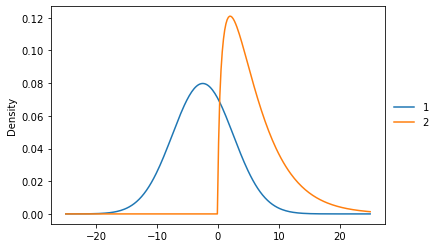

In [294]:
t_dists = {1: {1: 0.95, 2: 0.05},
           2: {1: 0.1, 2: 0.9}}
e_dists = {1: stats.norm(loc=-2.5, scale=25**0.5),  # Scale is standard deviation
           2: stats.gamma(a=1.5, scale=16**0.5)}
start_dist = {1: 0.5, 2: 0.5}

xs = np.linspace(-25, 25, 250)
ys1 = e_dists[1].pdf(xs)
ys2 = e_dists[2].pdf(xs)

plt.plot(xs, ys1, label='1')
plt.plot(xs, ys2, label='2')
plt.ylabel('Density')
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

Though the densities are clearly distinct, they do have a non-trivial overlap. The gamma distribution is also noticeably skewed to the right.

Let's generate some data and look at a single example to get a sense of the kinds of sequences this HMM produces.

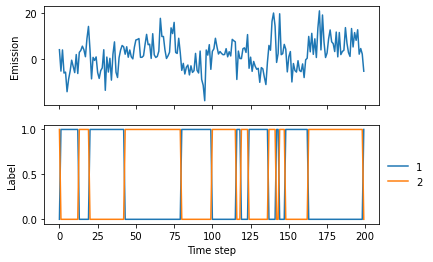

In [295]:
model = homomorph.HMM(t_dists=t_dists, e_dists=e_dists, start_dist=start_dist)

data = [model.simulate(200, random_state=i) for i in range(10)]  # Use a different random seed for each example
data = [list(zip(*example)) for example in data]

xs, ys = data[0]
lines = {}
for state in t_dists:
    lines[state] = [x == state for x in xs]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(ys)
for state, line in sorted(lines.items()):
    axs[1].plot(line, label=state)
axs[1].set_xlabel('Time step')
axs[0].set_ylabel('Emission')
axs[1].set_ylabel('Label')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

It's apparent there are alternating high and low intervals. However, as a result of the overlap between the emission distributions, the boundaries are not always clearcut.

We'll now fit models with normally distributed emissions using both training methods, beginning with maximum likelihood. The following code implements the same maximum likelihood estimators derived in previous sections. However, because this is an advanced example, I'll do the calculations with NumPy arrays. Because NumPy arrays vectorize basic arithmetic operations, this is generally more efficient and cleaner than iterating over each state-emission pair in a for loop.

In [296]:
xstack = np.stack([xs for xs, ys in data])
ystack = np.stack([ys for xs, ys in data])

# Make estimated transition distributions
t_dists_ML = {}
for state1, t_dist in t_dists.items():
    t_dist_ML = {}
    x1 = (xstack[:, :-1] == state1)
    x1_sum = x1.sum()
    for state2 in t_dist:
        x2 = (xstack[:, 1:] == state2)
        x12_sum = (x1 & x2).sum()
        t_dist_ML[state2] = x12_sum / x1_sum
    t_dists_ML[state1] = t_dist_ML
print('ML ESTIMATED T_DISTS')
for state, t_dist_ML in t_dists_ML.items():
    print(f'{state}: {t_dist_ML}')
print()

# Make estimated emission distributions
e_params_ML = {}
for state in e_dists:
    xs = xstack.ravel() == state
    ys = ystack.ravel()[xs]
    loc = ys.mean()
    scale = ys.var()
    e_params_ML[state] = {'mu': loc, 'sigma2': scale}
print('ML ESTIMATED E_PARAMS')
for state, e_param_ML in e_params_ML.items():
    print(f'{state}: {e_param_ML}')
print()

# Make estimated start distribution
start_dist_ML = {}
for state in start_dist:
    start_dist_ML[state] = (xstack[:, 0] == state).sum() / xstack.shape[0]
print('ML ESTIMATED START_DIST')
print(start_dist_ML)

ML ESTIMATED T_DISTS
1: {1: 0.9470684039087948, 2: 0.052931596091205214}
2: {1: 0.08923884514435695, 2: 0.910761154855643}

ML ESTIMATED E_PARAMS
1: {'mu': -2.708260094140367, 'sigma2': 24.878695602046125}
2: {'mu': 5.875899028606219, 'sigma2': 22.49724725215567}

ML ESTIMATED START_DIST
{1: 0.3, 2: 0.7}


Let's now tackle conditional maximum likelihood training, and after we'll compare the two. Because the implementation is somewhat lengthy, I've written it as the function `fit_CML` in the accompanying `utils` module. We only have to supply all the pieces. Each set of parameters we're estimating requires an initial estimate. As with the EM algorithm, it's best practice to inject some randomness into these initial values and choose the best result after several runs. For simplicity, though, we'll use the ML estimates directly. Because `t_dists` and `start_dist` will always take the form of a nested dictionary and dictionary, respectively, `fit_CML` accepts these objects as is. The emission distributions are more complex, however, because we need to supply the 1) parameter names and their initial estimates, 2) the emission probability or density functions, 3) the derivatives relative to each parameter, 4) functions which transform any constrained parameters to their auxiliary variables and 5) corresponding functions which reverse the transformation. Accordingly, each of these is supplied as a separate argument in the form of simple or nested dictionaries.

Fortunately, the ML parameter estimates are already in the proper form, so we can go directly to the emission density functions. The hardest part here is choosing our parameters and their names since they must be consistent throughout all the functions we define. We'll use the names `mu` and `sigma2`, so they correspond to the equations we derived in the previous section. These parameters, however, do differ from slightly from those used by the SciPy statistics module, we'll convert them when calling its implementation of the normal density function.

In [297]:
def norm_pdf(y, mu, sigma2):
    return stats.norm.pdf(y, loc=mu, scale=sigma2**0.5)

After defining our new density function, we simply map the states to it in a dictionary.

In [298]:
e_funcs = {1: norm_pdf,
           2: norm_pdf}

The derivatives require more explanation. As we saw before, the derivative of the conditional log-likelihood function involves a sum over a function that includes $n_i$ and  $m_i$. However, the terms involving those variables are the same for any emission distribution whose parameters are not shared between states, so it would be redundant to include them every time. Instead, the derivative relative to auxiliary variable $z$ must take the form

$$
\frac{\partial L}{\partial z}
= -\left[
         \sum_t \left( m_i(t) - n_i(t) \right)
                f(y_t)
   \right],
$$

and we only provide the function $f$ as the "derivative." Note the derivative is relative to an unconstrained auxiliary variable. For unconstrained parameters, there is no difference, but the derivatives of constrained parameters must be relative to their unconstrained auxiliary variables. These functions must also accept the emissions $y$ as their first argument and the parameters by their names as the subsequent arguments. Finally, because the parameters and their auxiliary variables are passed into the derivative functions, they must allow a variable number of keyword arguments with the `**kwargs` syntax.

Though these requirements may sound complex, in practice they are fairly intuitive. For example, our derivatives are a straightforward translation of the expressions we found earlier.

In [299]:
def norm_prime_mu(y, mu, sigma2, **kwargs):
    return (y - mu) / sigma2


def norm_prime_sigma2(y, mu, sigma2, **kwargs):
    term1 = - 1 / sigma2
    term2 = (y - mu) ** 2 / sigma2 ** 2
    return 0.5 * (term1 + term2) * sigma2

These functions are then mapped to their corresponding state and parameter combination using a nested dictionary.

In [300]:
e_primes = {1: {'mu': norm_prime_mu, 'sigma2': norm_prime_sigma2},
            2: {'mu': norm_prime_mu, 'sigma2': norm_prime_sigma2}}

The two sets of variable transformation functions are defined and structured similarly. The auxiliary variables are named with the convention the corresponding auxiliary variable for parameter `param` is called `param_aux`.

In [301]:
def mu2aux(mu, **kwargs):
    return mu


def aux2mu(mu_aux, **kwargs):
    return mu_aux


def sigma22aux(sigma2, **kwargs):
    return log(sigma2)


def aux2sigma2(sigma2_aux, **kwargs):
    return exp(sigma2_aux)


e_param2aux = {1: {'mu': mu2aux, 'sigma2': sigma22aux},
               2: {'mu': mu2aux, 'sigma2': sigma22aux}}
e_aux2param = {1: {'mu': aux2mu, 'sigma2': aux2sigma2},
               2: {'mu': aux2mu, 'sigma2': aux2sigma2}}

We're finally ready to fit our model to the data! All we have to do now is pass our arguments into `fit_CML`. There are a few more optional parameters, but their meanings should be clear from the previous discussion.

In [302]:
params = fit_CML(data,
                 t_dists=t_dists_ML,
                 e_params=e_params_ML, e_funcs=e_funcs, e_primes=e_primes,
                 e_param2aux=e_param2aux, e_aux2param=e_aux2param,
                 start_dist=start_dist_ML, eta=1)
t_dists_CML, e_params_CML, start_dist_CML = params

ITERATION 0
log-likelihood: -192.00829026263864
Δlog-likelihood: None
t_dists: {1: {1: 0.9470684039087948, 2: 0.052931596091205214},
          2: {1: 0.08923884514435695, 2: 0.910761154855643}}
e_dists: {1: {'mu': -2.708260094140367, 'sigma2': 24.878695602046125},
          2: {'mu': 5.875899028606219, 'sigma2': 22.49724725215567}}
start_dist: {1: 0.3, 2: 0.7}

ITERATION 1
log-likelihood: -190.91951806016925
Δlog-likelihood: 1.0887722024693858
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.08923884514435695, 2: 0.910761154855643}}
e_dists: {1: {'mu': -2.707103442219855, 'sigma2': 24.99571150280772},
          2: {'mu': 5.8800097243581515, 'sigma2': 22.09392539635372}}
start_dist: {1: 0.24516382315468627, 2: 0.7548361768453138}

ITERATION 2
log-likelihood: -189.9410812994638
Δlog-likelihood: 0.9784367607054492
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.08923884514435695, 2: 0.910761154855643}}
e_dists: {1: {'mu': -2.7

ITERATION 22
log-likelihood: -179.66833768526146
Δlog-likelihood: 0.2715262143324253
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.08923884514435695, 2: 0.910761154855643}}
e_dists: {1: {'mu': -2.694362300315599, 'sigma2': 26.248095699601556},
          2: {'mu': 5.946553890021437, 'sigma2': 16.21126822972989}}
start_dist: {1: 0.03789315808521402, 2: 0.962106841914786}

ITERATION 23
log-likelihood: -179.41523616373263
Δlog-likelihood: 0.2531015215288335
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.08923884514435695, 2: 0.910761154855643}}
e_dists: {1: {'mu': -2.694300997020024, 'sigma2': 26.25209384437753},
          2: {'mu': 5.948813902483945, 'sigma2': 16.034686952576575}}
start_dist: {1: 0.036509409721530765, 2: 0.9634905902784692}

ITERATION 24
log-likelihood: -179.1798373603135
Δlog-likelihood: 0.23539880341911612
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.08923884514435695, 

ITERATION 42
log-likelihood: -177.01394259308177
Δlog-likelihood: 0.05715172674911173
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.08923884514435695, 2: 0.910761154855643}}
e_dists: {1: {'mu': -2.698813986077206, 'sigma2': 25.525147918041107},
          2: {'mu': 5.980895065495607, 'sigma2': 13.954035626844954}}
start_dist: {1: 0.022642443642890604, 2: 0.9773575563571094}

ITERATION 43
log-likelihood: -176.96068209990574
Δlog-likelihood: 0.0532604931760261
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.08923884514435695, 2: 0.910761154855643}}
e_dists: {1: {'mu': -2.6991734483434477, 'sigma2': 25.465205642185744},
          2: {'mu': 5.982144560198872, 'sigma2': 13.893188448835335}}
start_dist: {1: 0.02225459310459135, 2: 0.9777454068954087}

ITERATION 44
log-likelihood: -176.91100347235192
Δlog-likelihood: 0.04967862755381702
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.0892388451443

ITERATION 62
log-likelihood: -176.4109011978877
Δlog-likelihood: 0.014764724359565662
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.08923884514435695, 2: 0.910761154855643}}
e_dists: {1: {'mu': -2.7044153890544567, 'sigma2': 24.502042608163357},
          2: {'mu': 6.000414213410206, 'sigma2': 13.138443554918329}}
start_dist: {1: 0.017377695370769466, 2: 0.9826223046292305}

ITERATION 63
log-likelihood: -176.39710575138724
Δlog-likelihood: 0.013795446500466824
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.08923884514435695, 2: 0.910761154855643}}
e_dists: {1: {'mu': -2.7045888568059433, 'sigma2': 24.464236092680455},
          2: {'mu': 6.001141198244304, 'sigma2': 13.112773232472934}}
start_dist: {1: 0.01720881699165043, 2: 0.9827911830083497}

ITERATION 64
log-likelihood: -176.38421740134038
Δlog-likelihood: 0.012888350046864616
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.089238845

ITERATION 82
log-likelihood: -176.25540803907063
Δlog-likelihood: 0.003745311221564407
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.08923884514435695, 2: 0.910761154855643}}
e_dists: {1: {'mu': -2.70634486842205, 'sigma2': 23.949183122583836},
          2: {'mu': 6.011933088601532, 'sigma2': 12.771587592703373}}
start_dist: {1: 0.014877416354109269, 2: 0.9851225836458907}

ITERATION 83
log-likelihood: -176.25191173931103
Δlog-likelihood: 0.0034962997596039713
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.08923884514435695, 2: 0.910761154855643}}
e_dists: {1: {'mu': -2.706373527717304, 'sigma2': 23.9306422093016},
          2: {'mu': 6.012372614587657, 'sigma2': 12.75952116458549}}
start_dist: {1: 0.014789287844075754, 2: 0.9852107121559243}

ITERATION 84
log-likelihood: -176.2486477586151
Δlog-likelihood: 0.0032639806959195994
t_dists: {1: {1: 0.9470684039087948, 2: 0.0529315960912052},
          2: {1: 0.089238845144

The parameter estimates don't appear to have changed too drastically, but let's plot the density functions with the true parameters against the two estimated densities to get a better sense of how they differ.

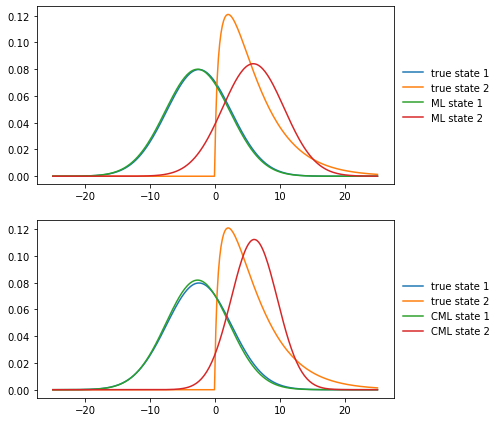

In [303]:
fig, axs = plt.subplots(2, 1, figsize=(6.4, 7.2))
xs = np.linspace(-25, 25, 250)

ys1 = e_dists[1].pdf(xs)
ys2 = e_dists[2].pdf(xs)
for ax in axs:
    ax.plot(xs, ys1, label='true state 1')
    ax.plot(xs, ys2, label='true state 2')

ys1 = stats.norm.pdf(xs, loc=e_params_ML[1]['mu'], scale=e_params_ML[1]['sigma2']**0.5)
ys2 = stats.norm.pdf(xs, loc=e_params_ML[2]['mu'], scale=e_params_ML[2]['sigma2']**0.5)
axs[0].plot(xs, ys1, label='ML state 1')
axs[0].plot(xs, ys2, label='ML state 2')
axs[0].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

ys1 = stats.norm.pdf(xs, loc=e_params_CML[1]['mu'], scale=e_params_CML[1]['sigma2']**0.5)
ys2 = stats.norm.pdf(xs, loc=e_params_CML[2]['mu'], scale=e_params_CML[2]['sigma2']**0.5)
axs[1].plot(xs, ys1, label='CML state 1')
axs[1].plot(xs, ys2, label='CML state 2')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

The change is most obvious for state 2 whose curve is much more peaked. However, even the state 1 has shifted slightly as well. These differences can be easily understood in terms of the objective functions. Maximum likelihood estimation chooses parameters that best describe the data, so the distribution is wider to account for the skew. In contrast, conditional maximum likelihood estimation chooses parameters that maximize prediction accuracy, so the distribution is narrower to better capture the decision boundary.

However, has all this work actually yielded an improvement in the accuracy of state inference? We can check by using the estimated models to calculate the probability of each state at each time step. Since these probabilities range continuously from zero to one, they are in a sense soft labels. To calculate accuracy, though, we need hard state assignments. There are any number of methods to convert the probabilities into states, but the easiest is using a threshold of 0.5. This is a natural choice because we have no reason to favor one state over the other, but in general, the threshold should reflect the costs making mistaken assignments for each state. For example, credit card companies err on the side of caution when alerting customers to potential fraud because the cost of confirming a valid transaction is much smaller than refunding a fraudulent one.

In [304]:
e_dists_ML = {}
for state, e_param_ML in e_params_ML.items():
    e_dists_ML[state] = stats.norm(loc=e_param_ML['mu'], scale=e_param_ML['sigma2']**0.5)
e_dists_CML = {}
for state, e_param_CML in e_params_CML.items():
    e_dists_CML[state] = stats.norm(loc=e_param_CML['mu'], scale=e_param_CML['sigma2']**0.5)
    
model_ML = homomorph.HMM(t_dists=t_dists_ML, e_dists=e_dists_ML, start_dist=start_dist_ML)
model_CML = homomorph.HMM(t_dists=t_dists_CML, e_dists=e_dists_CML, start_dist=start_dist_CML)

xstack_ML = []
xstack_CML = []
for example in data:
    _, ys = example
    fbs_ML = model_ML.forward_backward(ys)
    fbs_CML = model_CML.forward_backward(ys)
    
    xstack_ML.append(fbs_ML[1])
    xstack_CML.append(fbs_CML[1])
xstack_ML = np.stack(xstack_ML)
xstack_CML = np.stack(xstack_CML)

threshold = 0.5
accuracy_ML = ((xstack_ML >= threshold) == (xstack == 1)).sum()
accuracy_CML = ((xstack_CML >= threshold) == (xstack == 1)).sum()
print('ML accuracy:', accuracy_ML / xstack.size)
print('CML accuracy:', accuracy_CML / xstack.size)

ML accuracy: 0.948
CML accuracy: 0.9475


The CML trained model actually has a slight decrease in accuracy. However, we're not seeing the full picture by using a single threshold, and we should instead measure the models' responses as the threshold is varied continuously over the full range of the data. A commonly used implementation of this idea is the *receiver operating characteristic* (ROC) curve which plots the true positive rate against the false positive rate at varying thresholds. It essentially measures the trade-off between the increases in true and false positives as the threshold is decreased. Thus, a classifier with good separation between classes should rise steeply and rapidly level off. 

Let's plot the ROC curves for the two models.

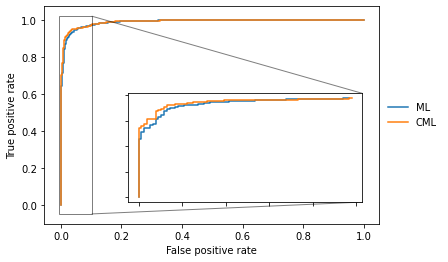

In [305]:
fpr_ML, tpr_ML, _ = metrics.roc_curve((xstack==1).ravel(), xstack_ML.ravel())
fpr_CML, tpr_CML, _ = metrics.roc_curve((xstack==1).ravel(), xstack_CML.ravel())


fig, ax = plt.subplots()
ax.plot(fpr_ML, tpr_ML, label='ML')
ax.plot(fpr_CML, tpr_CML, label='CML')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

idx_ML = fpr_ML <= 0.1
idx_CML = fpr_CML <= 0.1
axins = ax.inset_axes([0.25, 0.1, 0.7, 0.5])
axins.plot(fpr_ML[idx_ML], tpr_ML[idx_ML], label='ML')
axins.plot(fpr_CML[idx_CML], tpr_CML[idx_CML], label='CML')
axins.set_xticklabels([])
axins.set_yticklabels([])
ax.indicate_inset_zoom(axins, edgecolor="black");

A small effect but an effect nonetheless! Because in this case the ML model was already close to the true model, the improvement in the discriminatively trained model was fairly marginal. However, the greater the mismatch between the data and a model, the greater the effect on state inference, so for real data the difference between the two approaches can be substantial.

## 5 Conclusion

We have at last reached the end of the training tutorial!